## Importing Necessary Libraries

In [1]:
# These libraries will be used for EDA and data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# These libraries will be used for machine learning models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Importing csv with engineered features and merging them 

In [2]:
pd.set_option('display.max_columns', 100) # shows all the columns

# loading all the datasets
features_1 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/new_features.csv') # Suborna
features_2 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/Final_Provider.csv') # Anthony
features_2 = features_2.fillna(0)

# dropping because this column already exist in features_2, we don't need duplicates
features_1 = features_1.drop('PotentialFraud', axis = 1) 

# merging features_1 & features_2 to have the complete dataset of new features
All_Features = features_1.merge(features_2, on = 'Provider')

# setting provider as index for ML modeling
Train_set = features_1.merge(features_2, on = 'Provider').set_index('Provider')

# replacing categories with ordinal data for the Potential Fraud labels
Train_set['PotentialFraud'] = Train_set['PotentialFraud'].replace(['Yes', 'No'], [1,0])

# seperating the dataset into 2 frames: fraud & not fraud
## Potential Fraud dataset
fraud_df = All_Features.loc[All_Features.PotentialFraud == 'Yes']
Fraud_df = fraud_df.reset_index().rename(columns = {'index': 'Index'})

## Not Potential Fraud Dataset
nfraud_df = All_Features.loc[All_Features.PotentialFraud == 'No']
NFraud_df = nfraud_df.reset_index().rename(columns = {'index': 'Index'})

In [3]:
Train_set.isnull().sum().sum()

0

In [8]:
All_Features.shape # checking the count of rows and columns

(5410, 61)

In [5]:
# check the distribution of the potential fraud/Nfraud labels (0 means not potential fraud, 1 means potential fraud)
np.round(Train_set.PotentialFraud.value_counts()/All_Features.shape[0], 2)

0    0.91
1    0.09
Name: PotentialFraud, dtype: float64

In [6]:
All_Features.sample(5) # randomly sampling 5 rows of data

,Provider,Male_Patient,Female_Patient,Age(26-40),Age(41-60),Age(61-80),Age(81-100),Race_White,Race_Black,Race_Hispanic,Race_Native,Hos_Stay_Total,Payment_Total,Claim_Len_Total,Alzheimer,Heartfailure,KidneyDisease,Cancer,ObstrPulmonary,Depression,Diabetes,IschemicHeart,Osteoporasis,rheumatoidarthritis,stroke,RenalDisease,State_Count,County_Count,DiagGroupCode,PotentialFraud,DGC__882,DGC__884,DGC__166,DGC__183,DGC__939,DGC__883,DGC__168,DGC__887,DGC__204,DGC__876,CDC__2449,CDC__25000,CDC__2720,CDC__2724,CDC__4011,CDC__4019,CDC__42731,CDC__4280,CDC__53081,CDC__V5861,CDC__V5869,CPC__4019.0,CPC__2724.0,CPC__9904.0,CPC__8154.0,CPC__66.0,CPC__3893.0,CPC__3995.0,CPC__4516.0,CPC__3722.0,CPC__8151.0
4610,PRV57376,10.0,8.0,0.0,5.0,10.0,3.0,14.0,2.0,1.0,1.0,0.0,5060.0,12,6,14,7,0,13,7,12,15,8,5,2,6,1,3,0.0,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,2,1,3,0,0.0,1.0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3957,PRV53850,6.0,4.0,1.0,1.0,5.0,3.0,9.0,0.0,1.0,0.0,0.0,1720.0,33,3,6,3,0,5,5,5,7,3,3,4,2,1,1,0.0,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,2,1,4,2,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5098,PRV51753,1.0,3.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,1210.0,21,1,3,1,0,1,1,2,3,1,1,0,1,1,1,0.0,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4318,PRV52026,9.0,14.0,2.0,1.0,16.0,4.0,20.0,2.0,1.0,0.0,0.0,6960.0,62,13,14,11,6,8,9,18,17,8,6,5,4,5,6,0.0,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1,2,3,1,0.0,0.0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
528,PRV54720,6.0,3.0,1.0,0.0,4.0,4.0,9.0,0.0,0.0,0.0,35.0,135544.0,35,3,5,3,1,2,2,7,7,3,3,1,2,1,2,9.0,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,2,1,0,2,0,0.0,2.0,1,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# Baseline model (Logistic Regression, No Penalty)

In [9]:
# Create instance of Logistic Regression Class
lm = LogisticRegression(class_weight = 'balanced', solver = 'saga', random_state = 42, max_iter = 10000)

In [10]:
# preparing dataset for train, test, split
X = Train_set.drop('PotentialFraud', axis = 1)
y = Train_set['PotentialFraud']

# spliting the dataset into training set & testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

# fitting the logistic regression model
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [11]:
print('Train Set Score')
print(lm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(lm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9870609981515711
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9852125693160814
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1433   11]
 [  13  166]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1444
           1       0.94      0.93      0.93       179

    accuracy                           0.99      1623
   macro avg       0.96      0.96      0.96      1623
weighted avg       0.99      0.99      0.99      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


In [12]:
Features = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients'])
Features.loc[Features.Coefficients > 0.099].sort_values(ascending = False, by = 'Coefficients')

,Coefficients
CDC__4280,6.506166
Payment_Total,2.238017
Hos_Stay_Total,1.857791
Claim_Len_Total,0.984438
DiagGroupCode,0.840037
RenalDisease,0.536132
CPC__66.0,0.501357
CDC__42731,0.443673
Age(41-60),0.398666
State_Count,0.395517


# Logistic Regression (Lasso Penalty for Feature Selection)

In [13]:
X = Train_set.drop('PotentialFraud', axis = 1)
y = Train_set['PotentialFraud']

# spliting the dataset into training set & testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

In [24]:
# Grid Search 
params = {'C' : [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3], 'penalty': ['l1']}
gs_lr = GridSearchCV(lm, params, cv = 3, scoring = 'accuracy')

%time gs_lr.fit(X_train, y_train)

CPU times: user 3min 15s, sys: 1.65 s, total: 3min 16s
Wall time: 3min 17s


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=0.2, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3],
                         'penalty': ['l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [25]:
print('Best Params:', gs_lr.best_params_)
print('Best Score:', gs_lr.best_score_)

Best Params: {'C': 0.15, 'penalty': 'l1'}
Best Score: 0.9891743929692215


In [26]:
# Using Grid Search Hyperparameters for Featue Selection with Lasso Penalty
lm.set_params(class_weight = 'balanced', solver = 'saga', random_state = 42, C = 0.15, penalty = 'l1')
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [27]:
lm.get_params # checking the parameters 

<bound method BaseEstimator.get_params of LogisticRegression(C=0.15, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=42, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)>

In [28]:
print('Train Set Score')
print(lm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(lm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9894375495114867
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9870609981515711
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1436    8]
 [  13  166]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1444
           1       0.95      0.93      0.94       179

    accuracy                           0.99      1623
   macro avg       0.97      0.96      0.97      1623
weighted avg       0.99      0.99      0.99      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


- C = 0.15 increased false positive by 2 and decreased false negative by 2 compared to 0.1.

In [29]:
Features = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients'])
Features.loc[Features.Coefficients > 0].sort_values(ascending = False, by = 'Coefficients').index

Index(['CDC__4280', 'Payment_Total', 'Hos_Stay_Total', 'Claim_Len_Total',
       'DiagGroupCode', 'CPC__66.0', 'State_Count', 'CPC__8154.0', 'DGC__887',
       'CPC__4516.0', 'CDC__42731'],
      dtype='object')

# Logistic Regression (Lasso Features)

In [34]:
# Using Lasso Feature Selection and Grid Search Hypermarameters & running Log Regression
lm = LogisticRegression(class_weight = 'balanced', solver = 'saga', random_state = 42, C = 0.15, max_iter = 10000)

X = Train_set[['CDC__4280', 'Payment_Total', 'Hos_Stay_Total', 'Claim_Len_Total',
       'DiagGroupCode', 'CPC__66.0', 'State_Count', 'CPC__8154.0', 'DGC__887',
       'CPC__4516.0', 'CDC__42731']]
               
y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [35]:
print('Train Set Score')
print(lm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(lm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9801954053340375
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9741219963031423
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1429   15]
 [  27  152]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1444
           1       0.91      0.85      0.88       179

    accuracy                           0.97      1623
   macro avg       0.95      0.92      0.93      1623
weighted avg       0.97      0.97      0.97      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


In [36]:
Features = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients'])
Features.sort_values(ascending = False, by = 'Coefficients')

,Coefficients
CDC__4280,6.759312
Hos_Stay_Total,0.825296
Payment_Total,0.793565
CPC__66.0,0.293860
CPC__8154.0,0.084593
DGC__887,0.058527
CPC__4516.0,-0.008297
State_Count,-0.034982
DiagGroupCode,-0.232931
Claim_Len_Total,-0.257926


# Random Forest (Lasso Features)

In [37]:
rf = RandomForestClassifier(class_weight = 'balanced')

X = Train_set[['CDC__4280', 'Payment_Total', 'Hos_Stay_Total', 'Claim_Len_Total',
       'DiagGroupCode', 'CPC__66.0', 'State_Count', 'CPC__8154.0', 'DGC__887',
       'CPC__4516.0', 'CDC__42731']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

###############################################

# Grid Search
params = {'n_estimators' : range(25, 50, 5), 'max_depth' : range(3, 7), 'max_features' : range(3,7), \
          'min_samples_leaf' : range(1,5), 'min_samples_split' : range(3,7)}

gs_rf = GridSearchCV(rf, params, cv = 3, scoring = 'accuracy')
%time gs_rf.fit(X_train, y_train)

CPU times: user 6min 18s, sys: 3.87 s, total: 6min 22s
Wall time: 6min 26s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [38]:
print('Best Params:', gs_rf.best_params_)
print('Best Score:', gs_rf.best_score_)

Best Params: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 40}
Best Score: 0.9965665060131107


In [39]:
# Setting the optimized hyperparameters
rf.set_params(n_estimators = 40, verbose = 1, warm_start = False, min_samples_split = 3, min_samples_leaf = 1, max_depth = 3, max_features = 3)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [40]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)>

In [41]:
print('Train Set Score')
print(rf.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(rf.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9965672035912332
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9932224276032039
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1444    0]
 [  11  168]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1444
           1       1.00      0.94      0.97       179

    accuracy                           0.99      1623
   macro avg       1.00      0.97      0.98      1623
weighted avg       0.99      0.99      0.99      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [46]:
Feature_importance = pd.DataFrame(sorted(zip(X.columns, rf.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_importance.loc[Feature_importance.Importance > 0.009]

,FeatureName,Importance
0,CDC__4280,0.461057
1,Payment_Total,0.203248
2,Claim_Len_Total,0.097494
3,Hos_Stay_Total,0.096690
4,CDC__42731,0.066157
5,DiagGroupCode,0.027377
6,CPC__66.0,0.023373
7,CPC__8154.0,0.022874
8,CPC__4516.0,0.001047
9,State_Count,0.000682


# Random Forest (All Features)

In [97]:
rf = RandomForestClassifier(class_weight = 'balanced')

X = Train_set.drop('PotentialFraud', axis = 1)

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

###############################################

# Grid Search
params = {'n_estimators' : range(25, 50, 5), 'max_depth' : range(3, 7), 'max_features' : range(3,7), \
          'min_samples_leaf' : range(1,5), 'min_samples_split' : range(3,7)}

gs_rf = GridSearchCV(rf, params, cv = 3, scoring = 'accuracy')
%time gs_rf.fit(X_train, y_train)

CPU times: user 7min 22s, sys: 5.71 s, total: 7min 27s
Wall time: 7min 50s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [98]:
print('Best Params:', gs_rf.best_params_)
print('Best Score:', gs_rf.best_score_)

Best Params: {'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40}
Best Score: 0.9957741129861694


In [102]:
# Setting the optimized hyperparameters
rf.set_params(n_estimators = 40, verbose = 1, min_samples_split = 5, min_samples_leaf = 1, max_depth = 6, max_features = 6)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [103]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)>

In [104]:
print('Train Set Score')
print(rf.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(rf.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9978875099022974
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9932224276032039
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1444    0]
 [  11  168]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1444
           1       1.00      0.94      0.97       179

    accuracy                           0.99      1623
   macro avg       1.00      0.97      0.98      1623
weighted avg       0.99      0.99      0.99      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


# Gradient Boosting (Lasso Features)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [53]:
gbm = GradientBoostingClassifier(random_state = 42) # creating an instance of the Class, GB does not need class weight

X = Train_set[['CDC__4280', 'Payment_Total', 'Hos_Stay_Total', 'Claim_Len_Total',
       'DiagGroupCode', 'CPC__66.0', 'State_Count', 'CPC__8154.0', 'DGC__887',
       'CPC__4516.0', 'CDC__42731']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

#########################################################

params = [{
    "learning_rate": [0.01],
    "n_estimators": range(500, 2000, 500),
    "max_depth": range(1, 5),
    "max_features": range(1, 6),  #  sqrt(number of samples) 
    "min_impurity_decrease": [0.01], 
    "min_samples_split": range(2, 6), # having 1 does not make sense, so min starts from 2
    "random_state": [42] }]

gs_gbm = GridSearchCV(gbm, params, cv = 3, scoring = 'accuracy')
%time gs_gbm.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5857            1.02s
         2           0.5839            1.16s
         3           0.5657            1.11s
         4           0.5626            1.09s
         5           0.5464            1.08s
         6           0.5416            1.08s
         7           0.5384            1.08s
         8           0.5352            1.07s
         9           0.5323            1.07s
        10           0.5279            1.07s
        20           0.4891            0.89s
        30           0.4604            0.83s
        40           0.4320            0.79s
        50           0.3935            0.76s
        60           0.3824            0.73s
        70           0.3673            0.67s
        80           0.3522            0.64s
        90           0.3383            0.60s
       100           0.3332            0.58s
       200           0.2581            0.37s
       300           0.2087            0.23s
       40

       600           0.1541            0.78s
       700           0.1436            0.71s
       800           0.1378            0.62s
       900           0.1272            0.56s
      1000           0.1198            0.47s
      Iter       Train Loss   Remaining Time 
         1           0.5852            2.38s
         2           0.5838            2.16s
         3           0.5654            2.07s
         4           0.5624            1.98s
         5           0.5462            1.91s
         6           0.5416            1.88s
         7           0.5383            1.84s
         8           0.5353            1.84s
         9           0.5324            1.85s
        10           0.5279            1.87s
        20           0.4901            1.55s
        30           0.4615            1.42s
        40           0.4330            1.34s
        50           0.3948            1.30s
        60           0.3839            1.30s
        70           0.3693            1.30s
        8

       300           0.2096            0.60s
       400           0.1967            0.51s
       500           0.1739            0.42s
       600           0.1541            0.33s
       700           0.1433            0.25s
       800           0.1372            0.17s
       900           0.1262            0.08s
      1000           0.1186            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5853            1.31s
         2           0.5837            1.32s
         3           0.5646            1.31s
         4           0.5618            1.28s
         5           0.5448            1.26s
         6           0.5407            1.24s
         7           0.5375            1.22s
         8           0.5342            1.22s
         9           0.5312            1.22s
        10           0.5270            1.23s
        20           0.4887            1.02s
        30           0.4608            0.93s
        40           0.4302            0.89s
        5

        30           0.4608            0.50s
        40           0.4302            0.48s
        50           0.3900            0.48s
        60           0.3789            0.45s
        70           0.3635            0.44s
        80           0.3481            0.42s
        90           0.3345            0.40s
       100           0.3298            0.39s
       200           0.2496            0.26s
       300           0.1961            0.18s
       400           0.1833            0.09s
       500           0.1582            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5857            1.82s
         2           0.5839            1.66s
         3           0.5657            1.58s
         4           0.5626            1.54s
         5           0.5464            1.51s
         6           0.5416            1.49s
         7           0.5384            1.50s
         8           0.5352            1.51s
         9           0.5323            1.55s
        1

       900           0.1037            0.51s
      1000           0.0946            0.42s
      Iter       Train Loss   Remaining Time 
         1           0.5857            0.87s
         2           0.5839            0.74s
         3           0.5657            0.71s
         4           0.5626            0.68s
         5           0.5464            0.66s
         6           0.5416            0.65s
         7           0.5384            0.64s
         8           0.5352            0.63s
         9           0.5323            0.63s
        10           0.5279            0.63s
        20           0.4891            0.51s
        30           0.4604            0.46s
        40           0.4320            0.42s
        50           0.3935            0.43s
        60           0.3824            0.43s
        70           0.3673            0.41s
        80           0.3522            0.39s
        90           0.3383            0.38s
       100           0.3332            0.37s
       20

       500           0.1734            0.85s
       600           0.1541            0.75s
       700           0.1436            0.66s
       800           0.1378            0.58s
       900           0.1272            0.50s
      1000           0.1198            0.41s
      Iter       Train Loss   Remaining Time 
         1           0.5852            2.42s
         2           0.5838            2.15s
         3           0.5654            2.07s
         4           0.5624            2.01s
         5           0.5462            1.97s
         6           0.5416            1.92s
         7           0.5383            1.87s
         8           0.5353            1.86s
         9           0.5324            1.90s
        10           0.5279            1.91s
        20           0.4901            1.57s
        30           0.4615            1.43s
        40           0.4330            1.35s
        50           0.3948            1.32s
        60           0.3839            1.29s
        7

       200           0.2148            0.75s
       300           0.1622            0.64s
       400           0.1371            0.54s
       500           0.1162            0.46s
       600           0.1032            0.36s
       700           0.0943            0.27s
       800           0.0868            0.18s
       900           0.0798            0.09s
      1000           0.0746            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5839            1.58s
         2           0.5807            1.42s
         3           0.5619            1.33s
         4           0.5591            1.30s
         5           0.5424            1.29s
         6           0.5384            1.27s
         7           0.5235            1.25s
         8           0.5193            1.25s
         9           0.5163            1.26s
        10           0.5124            1.25s
        20           0.4734            1.09s
        30           0.4363            1.07s
        4

        30           0.4363            0.51s
        40           0.4053            0.49s
        50           0.3649            0.50s
        60           0.3546            0.47s
        70           0.3357            0.45s
        80           0.3178            0.43s
        90           0.3050            0.41s
       100           0.2972            0.40s
       200           0.2010            0.28s
       300           0.1438            0.19s
       400           0.1161            0.09s
       500           0.0919            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5839            1.41s
         2           0.5802            1.35s
         3           0.5624            1.31s
         4           0.5594            1.28s
         5           0.5435            1.26s
         6           0.5388            1.24s
         7           0.5247            1.22s
         8           0.5205            1.28s
         9           0.5177            1.40s
        1

       800           0.0571            0.81s
       900           0.0489            0.67s
      1000           0.0431            0.55s
      Iter       Train Loss   Remaining Time 
         1           0.5839            0.75s
         2           0.5802            0.70s
         3           0.5624            0.67s
         4           0.5594            0.65s
         5           0.5435            0.63s
         6           0.5388            0.62s
         7           0.5247            0.61s
         8           0.5205            0.61s
         9           0.5177            0.61s
        10           0.5135            0.61s
        20           0.4727            0.52s
        30           0.4365            0.47s
        40           0.4062            0.45s
        50           0.3687            0.43s
        60           0.3582            0.41s
        70           0.3401            0.40s
        80           0.3231            0.40s
        90           0.3109            0.42s
       10

       200           0.2144            1.22s
       300           0.1628            1.11s
       400           0.1382            1.00s
       500           0.1178            0.92s
       600           0.1052            0.81s
       700           0.0968            0.72s
       800           0.0897            0.63s
       900           0.0829            0.54s
      1000           0.0779            0.44s
      Iter       Train Loss   Remaining Time 
         1           0.5842            2.42s
         2           0.5809            2.20s
         3           0.5629            2.15s
         4           0.5599            2.04s
         5           0.5439            1.96s
         6           0.5393            1.92s
         7           0.5250            1.87s
         8           0.5207            1.90s
         9           0.5179            1.91s
        10           0.5138            1.90s
        20           0.4739            1.59s
        30           0.4375            1.48s
        4

       200           0.2148            0.74s
       300           0.1622            0.65s
       400           0.1371            0.55s
       500           0.1162            0.46s
       600           0.1032            0.36s
       700           0.0943            0.27s
       800           0.0868            0.18s
       900           0.0798            0.09s
      1000           0.0746            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5839            1.58s
         2           0.5807            1.43s
         3           0.5619            1.37s
         4           0.5591            1.35s
         5           0.5424            1.31s
         6           0.5384            1.27s
         7           0.5235            1.26s
         8           0.5193            1.32s
         9           0.5163            1.34s
        10           0.5124            1.33s
        20           0.4734            1.22s
        30           0.4363            1.14s
        4

       200           0.1540            0.38s
       300           0.0993            0.24s
       400           0.0743            0.12s
       500           0.0576            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5839            1.42s
         2           0.5657            1.41s
         3           0.5492            1.39s
         4           0.5343            1.37s
         5           0.5205            1.34s
         6           0.5161            1.32s
         7           0.5036            1.33s
         8           0.4996            1.33s
         9           0.4958            1.32s
        10           0.4922            1.31s
        20           0.4458            1.14s
        30           0.4059            1.06s
        40           0.3760            1.02s
        50           0.3390            0.98s
        60           0.3249            0.98s
        70           0.3084            0.98s
        80           0.2910            0.96s
        9

       300           0.1245            0.19s
       400           0.1029            0.09s
       500           0.0895            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5842            0.68s
         2           0.5658            0.67s
         3           0.5492            0.67s
         4           0.5341            0.65s
         5           0.5203            0.65s
         6           0.5160            0.64s
         7           0.5035            0.63s
         8           0.4993            0.64s
         9           0.4956            0.66s
        10           0.4918            0.69s
        20           0.4467            0.64s
        30           0.4069            0.65s
        40           0.3779            0.66s
        50           0.3404            0.61s
        60           0.3271            0.57s
        70           0.3111            0.54s
        80           0.2935            0.52s
        90           0.2806            0.49s
       10

       300           0.1222            1.17s
       400           0.1004            1.05s
       500           0.0867            0.94s
       600           0.0774            0.86s
       700           0.0709            0.76s
       800           0.0657            0.66s
       900           0.0615            0.58s
      1000           0.0582            0.48s
      Iter       Train Loss   Remaining Time 
         1           0.5839            2.74s
         2           0.5647            2.48s
         3           0.5474            2.46s
         4           0.5317            2.59s
         5           0.5172            2.54s
         6           0.5135            2.44s
         7           0.5004            2.39s
         8           0.4965            2.34s
         9           0.4933            2.30s
        10           0.4897            2.28s
        20           0.4436            1.85s
        30           0.4024            1.69s
        40           0.3725            1.62s
        5

       100           0.2601            0.92s
       200           0.1540            0.83s
       300           0.0993            0.70s
       400           0.0743            0.71s
       500           0.0576            0.67s
       600           0.0462            0.52s
       700           0.0382            0.37s
       800           0.0325            0.25s
       900           0.0281            0.12s
      1000           0.0250            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5839            3.67s
         2           0.5657            3.02s
         3           0.5492            2.85s
         4           0.5343            2.70s
         5           0.5205            2.63s
         6           0.5161            2.57s
         7           0.5036            2.52s
         8           0.4996            2.50s
         9           0.4958            2.60s
        10           0.4922            2.58s
        20           0.4458            2.09s
        3

       200           0.1733            1.24s
       300           0.1245            0.97s
       400           0.1029            0.81s
       500           0.0895            0.73s
       600           0.0805            0.71s
       700           0.0743            0.50s
       800           0.0693            0.33s
       900           0.0652            0.18s
      1000           0.0620            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5842            1.42s
         2           0.5658            1.36s
         3           0.5492            1.33s
         4           0.5341            1.31s
         5           0.5203            1.30s
         6           0.5160            1.29s
         7           0.5035            1.28s
         8           0.4993            1.30s
         9           0.4956            1.30s
        10           0.4918            1.28s
        20           0.4467            1.18s
        30           0.4069            1.09s
        4

       200           0.1437            0.36s
       300           0.1012            0.24s
       400           0.0824            0.12s
       500           0.0720            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5815            1.09s
         2           0.5626            1.04s
         3           0.5455            0.99s
         4           0.5299            0.95s
         5           0.5156            0.94s
         6           0.5023            0.91s
         7           0.4900            0.88s
         8           0.4862            0.86s
         9           0.4831            0.85s
        10           0.4796            0.84s
        20           0.4280            0.69s
        30           0.3742            0.63s
        40           0.3432            0.60s
        50           0.3080            0.57s
        60           0.2880            0.56s
        70           0.2674            0.54s
        80           0.2472            0.53s
        9

       200           0.1229            1.38s
       300           0.0750            1.28s
       400           0.0528            1.19s
       500           0.0396            1.09s
       600           0.0312            0.96s
       700           0.0266            0.85s
       800           0.0235            0.76s
       900           0.0208            0.74s
      1000           0.0193            0.62s
      Iter       Train Loss   Remaining Time 
         1           0.5810            0.95s
         2           0.5631            0.79s
         3           0.5469            0.76s
         4           0.5321            0.72s
         5           0.5185            0.73s
         6           0.5059            0.71s
         7           0.4942            0.70s
         8           0.4903            0.70s
         9           0.4866            0.70s
        10           0.4830            0.69s
        20           0.4319            0.58s
        30           0.3808            0.53s
        4

       200           0.1458            1.44s
       300           0.1037            1.30s
       400           0.0850            1.16s
       500           0.0750            1.06s
       600           0.0685            0.94s
       700           0.0642            0.83s
       800           0.0610            0.73s
       900           0.0579            0.63s
      1000           0.0557            0.54s
      Iter       Train Loss   Remaining Time 
         1           0.5809            2.37s
         2           0.5629            2.13s
         3           0.5466            2.11s
         4           0.5317            2.03s
         5           0.5180            2.08s
         6           0.5053            2.07s
         7           0.4935            2.06s
         8           0.4895            2.06s
         9           0.4859            2.05s
        10           0.4822            2.05s
        20           0.4319            1.79s
        30           0.3804            1.66s
        4

       200           0.1437            0.84s
       300           0.1012            0.74s
       400           0.0824            0.62s
       500           0.0720            0.52s
       600           0.0652            0.42s
       700           0.0608            0.31s
       800           0.0575            0.21s
       900           0.0544            0.10s
      1000           0.0521            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5815            2.01s
         2           0.5626            2.01s
         3           0.5455            1.87s
         4           0.5299            1.79s
         5           0.5156            1.79s
         6           0.5023            1.72s
         7           0.4900            1.69s
         8           0.4862            1.72s
         9           0.4831            1.70s
        10           0.4796            1.72s
        20           0.4280            1.38s
        30           0.3742            1.24s
        4

       200           0.1229            0.30s
       300           0.0750            0.20s
       400           0.0528            0.10s
       500           0.0396            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5810            1.65s
         2           0.5631            1.61s
         3           0.5469            1.55s
         4           0.5321            1.47s
         5           0.5185            1.47s
         6           0.5059            1.45s
         7           0.4942            1.43s
         8           0.4903            1.42s
         9           0.4866            1.41s
        10           0.4830            1.40s
        20           0.4319            1.30s
        30           0.3808            1.28s
        40           0.3503            1.23s
        50           0.3169            1.24s
        60           0.2974            1.21s
        70           0.2778            1.17s
        80           0.2599            1.16s
        9

       200           0.1287            0.34s
       300           0.0907            0.22s
       400           0.0749            0.11s
       500           0.0672            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5809            0.85s
         2           0.5629            0.81s
         3           0.5466            0.78s
         4           0.5317            0.76s
         5           0.5180            0.77s
         6           0.5053            0.75s
         7           0.4935            0.74s
         8           0.4891            0.74s
         9           0.4855            0.74s
        10           0.4818            0.73s
        20           0.4215            0.61s
        30           0.3684            0.55s
        40           0.3365            0.53s
        50           0.3052            0.50s
        60           0.2867            0.48s
        70           0.2657            0.46s
        80           0.2448            0.47s
        9

       200           0.1262            1.38s
       300           0.0880            1.31s
       400           0.0720            1.25s
       500           0.0641            1.18s
       600           0.0591            1.10s
       700           0.0559            0.98s
       800           0.0535            0.87s
       900           0.0512            0.74s
      1000           0.0494            0.60s
      Iter       Train Loss   Remaining Time 
         1           0.5815            2.59s
         2           0.5626            2.39s
         3           0.5455            2.33s
         4           0.5299            2.30s
         5           0.5156            2.32s
         6           0.5023            2.25s
         7           0.4900            2.22s
         8           0.4856            2.24s
         9           0.4825            2.22s
        10           0.4790            2.21s
        20           0.4168            1.88s
        30           0.3610            1.73s
        4

        80           0.2304            1.06s
        90           0.2149            1.08s
       100           0.1992            1.07s
       200           0.1030            0.91s
       300           0.0593            0.80s
       400           0.0401            0.68s
       500           0.0299            0.58s
       600           0.0241            0.46s
       700           0.0214            0.34s
       800           0.0197            0.23s
       900           0.0182            0.11s
      1000           0.0176            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5810            2.73s
         2           0.5631            2.68s
         3           0.5469            3.03s
         4           0.5321            3.12s
         5           0.5185            3.03s
         6           0.5059            2.84s
         7           0.4942            2.73s
         8           0.4894            2.69s
         9           0.4857            2.62s
        1

       200           0.1287            0.86s
       300           0.0907            0.80s
       400           0.0749            0.71s
       500           0.0672            0.61s
       600           0.0623            0.50s
       700           0.0592            0.37s
       800           0.0568            0.25s
       900           0.0546            0.12s
      1000           0.0528            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5809            1.98s
         2           0.5629            1.88s
         3           0.5466            1.96s
         4           0.5317            1.83s
         5           0.5180            1.79s
         6           0.5053            1.71s
         7           0.4935            1.69s
         8           0.4891            1.68s
         9           0.4855            1.66s
        10           0.4818            1.64s
        20           0.4215            1.33s
        30           0.3684            1.21s
        4

        50           0.3052            0.72s
        60           0.2867            0.72s
        70           0.2657            0.67s
        80           0.2448            0.65s
        90           0.2300            0.63s
       100           0.2156            0.60s
       200           0.1262            0.40s
       300           0.0880            0.25s
       400           0.0720            0.12s
       500           0.0641            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5815            0.94s
         2           0.5626            0.95s
         3           0.5455            0.95s
         4           0.5299            0.97s
         5           0.5156            1.00s
         6           0.5023            0.97s
         7           0.4900            0.94s
         8           0.4856            0.93s
         9           0.4825            0.91s
        10           0.4790            0.89s
        20           0.4168            0.71s
        3

       200           0.1030            1.40s
       300           0.0593            1.29s
       400           0.0401            1.19s
       500           0.0299            1.09s
       600           0.0241            0.97s
       700           0.0214            0.86s
       800           0.0197            0.75s
       900           0.0182            0.64s
      1000           0.0176            0.53s
      Iter       Train Loss   Remaining Time 
         1           0.5831            0.92s
         2           0.5800            0.82s
         3           0.5621            0.75s
         4           0.5563            0.74s
         5           0.5407            0.71s
         6           0.5345            0.71s
         7           0.5286            0.74s
         8           0.5246            0.73s
         9           0.5209            0.73s
        10           0.5161            0.73s
        20           0.4638            0.61s
        30           0.4337            0.56s
        4

       200           0.2024            1.50s
       300           0.1566            1.31s
       400           0.1353            1.19s
       500           0.1131            1.08s
       600           0.1007            0.95s
       700           0.0930            0.84s
       800           0.0891            0.72s
       900           0.0822            0.61s
      1000           0.0771            0.51s
      Iter       Train Loss   Remaining Time 
         1           0.5827            2.59s
         2           0.5801            2.36s
         3           0.5621            2.18s
         4           0.5564            2.18s
         5           0.5407            2.12s
         6           0.5349            2.10s
         7           0.5292            2.15s
         8           0.5256            2.15s
         9           0.5220            2.14s
        10           0.5173            2.15s
        20           0.4637            1.84s
        30           0.4333            1.71s
        4

        60           0.3480            1.18s
        70           0.3311            1.20s
        80           0.3111            1.21s
        90           0.2904            1.18s
       100           0.2824            1.16s
       200           0.2013            1.00s
       300           0.1545            0.91s
       400           0.1329            0.77s
       500           0.1092            0.64s
       600           0.0972            0.50s
       700           0.0897            0.36s
       800           0.0847            0.24s
       900           0.0786            0.11s
      1000           0.0737            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5828            1.48s
         2           0.5801            1.48s
         3           0.5614            1.42s
         4           0.5558            1.43s
         5           0.5394            1.39s
         6           0.5340            1.39s
         7           0.5283            1.42s
         

       200           0.1877            0.36s
       300           0.1369            0.23s
       400           0.1158            0.11s
       500           0.0898            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5831            1.54s
         2           0.5800            1.49s
         3           0.5621            1.40s
         4           0.5563            1.38s
         5           0.5407            1.34s
         6           0.5345            1.36s
         7           0.5286            1.40s
         8           0.5246            1.40s
         9           0.5209            1.41s
        10           0.5161            1.41s
        20           0.4638            1.21s
        30           0.4337            1.14s
        40           0.4039            1.08s
        50           0.3676            1.05s
        60           0.3486            1.02s
        70           0.3313            1.00s
        80           0.3103            1.02s
        9

       200           0.2024            0.33s
       300           0.1566            0.22s
       400           0.1353            0.11s
       500           0.1131            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5827            0.75s
         2           0.5801            0.74s
         3           0.5621            0.70s
         4           0.5564            0.71s
         5           0.5407            0.68s
         6           0.5349            0.69s
         7           0.5292            0.70s
         8           0.5256            0.70s
         9           0.5220            0.70s
        10           0.5173            0.70s
        20           0.4637            0.60s
        30           0.4333            0.55s
        40           0.4037            0.52s
        50           0.3682            0.50s
        60           0.3480            0.48s
        70           0.3311            0.46s
        80           0.3111            0.45s
        9

       200           0.2013            1.37s
       300           0.1545            1.29s
       400           0.1329            1.17s
       500           0.1092            1.06s
       600           0.0972            0.93s
       700           0.0897            0.83s
       800           0.0847            0.71s
       900           0.0786            0.60s
      1000           0.0737            0.49s
      Iter       Train Loss   Remaining Time 
         1           0.5828            2.84s
         2           0.5801            2.66s
         3           0.5614            2.47s
         4           0.5558            2.42s
         5           0.5394            2.30s
         6           0.5340            2.26s
         7           0.5283            2.27s
         8           0.5246            2.25s
         9           0.5210            2.23s
        10           0.5163            2.22s
        20           0.4650            1.89s
        30           0.4349            1.75s
        4

       100           0.2244            1.09s
       200           0.1236            0.95s
       300           0.0745            0.83s
       400           0.0542            0.70s
       500           0.0410            0.58s
       600           0.0349            0.45s
       700           0.0313            0.33s
       800           0.0288            0.21s
       900           0.0262            0.10s
      1000           0.0244            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5806            3.03s
         2           0.5742            3.08s
         3           0.5570            3.01s
         4           0.5504            2.95s
         5           0.5354            2.88s
         6           0.5298            2.80s
         7           0.5163            2.73s
         8           0.5060            2.68s
         9           0.5012            2.64s
        10           0.4969            2.58s
        20           0.4341            2.31s
        3

        60           0.3043            3.13s
        70           0.2841            3.13s
        80           0.2651            3.02s
        90           0.2495            2.88s
       100           0.2358            2.78s
       200           0.1443            2.10s
       300           0.1013            1.55s
       400           0.0835            1.18s
       500           0.0713            0.90s
       600           0.0640            0.67s
       700           0.0592            0.48s
       800           0.0562            0.30s
       900           0.0535            0.15s
      1000           0.0519            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5810            1.72s
         2           0.5750            1.62s
         3           0.5576            1.62s
         4           0.5516            1.72s
         5           0.5363            1.90s
         6           0.5309            1.89s
         7           0.5172            1.88s
         

        50           0.3255            0.57s
        60           0.3039            0.57s
        70           0.2845            0.61s
        80           0.2652            0.61s
        90           0.2498            0.61s
       100           0.2369            0.58s
       200           0.1426            0.39s
       300           0.0976            0.26s
       400           0.0789            0.12s
       500           0.0663            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5813            0.81s
         2           0.5754            0.79s
         3           0.5571            0.79s
         4           0.5516            0.80s
         5           0.5356            0.81s
         6           0.5303            0.83s
         7           0.5159            0.83s
         8           0.5057            0.85s
         9           0.4998            0.87s
        10           0.4956            0.88s
        20           0.4304            0.77s
        3

       200           0.1236            1.59s
       300           0.0745            1.44s
       400           0.0542            1.31s
       500           0.0410            1.19s
       600           0.0349            1.04s
       700           0.0313            0.90s
       800           0.0288            0.76s
       900           0.0262            0.64s
      1000           0.0244            0.52s
      Iter       Train Loss   Remaining Time 
         1           0.5806            0.91s
         2           0.5742            0.83s
         3           0.5570            0.82s
         4           0.5504            0.82s
         5           0.5354            0.80s
         6           0.5298            0.78s
         7           0.5163            0.77s
         8           0.5060            0.77s
         9           0.5012            0.76s
        10           0.4969            0.76s
        20           0.4341            0.67s
        30           0.3864            0.61s
        4

       200           0.1443            2.09s
       300           0.1013            1.81s
       400           0.0835            1.62s
       500           0.0713            1.41s
       600           0.0640            1.22s
       700           0.0592            1.04s
       800           0.0562            0.88s
       900           0.0535            0.74s
      1000           0.0519            0.60s
      Iter       Train Loss   Remaining Time 
         1           0.5810            2.83s
         2           0.5750            2.60s
         3           0.5576            2.54s
         4           0.5516            2.48s
         5           0.5363            2.44s
         6           0.5309            2.39s
         7           0.5172            2.35s
         8           0.5077            2.34s
         9           0.5016            2.34s
        10           0.4973            2.33s
        20           0.4351            2.06s
        30           0.3866            1.94s
        4

       200           0.1173            1.10s
       300           0.0790            0.95s
       400           0.0628            0.81s
       500           0.0537            0.67s
       600           0.0476            0.53s
       700           0.0446            0.39s
       800           0.0427            0.25s
       900           0.0412            0.12s
      1000           0.0399            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5808            2.59s
         2           0.5620            2.41s
         3           0.5450            2.30s
         4           0.5294            2.23s
         5           0.5152            2.30s
         6           0.5094            2.34s
         7           0.4965            2.31s
         8           0.4887            2.32s
         9           0.4846            2.31s
        10           0.4799            2.31s
        20           0.4148            1.89s
        30           0.3602            1.73s
        4

       200           0.0940            0.39s
       300           0.0522            0.26s
       400           0.0354            0.13s
       500           0.0253            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5805            1.84s
         2           0.5626            1.69s
         3           0.5464            1.65s
         4           0.5317            1.60s
         5           0.5181            1.58s
         6           0.5121            1.61s
         7           0.5000            1.59s
         8           0.4931            1.60s
         9           0.4886            1.59s
        10           0.4840            1.59s
        20           0.4202            1.52s
        30           0.3692            1.45s
        40           0.3362            1.39s
        50           0.3017            1.32s
        60           0.2770            1.33s
        70           0.2557            1.35s
        80           0.2367            1.36s
        9

       200           0.1188            0.39s
       300           0.0817            0.26s
       400           0.0660            0.13s
       500           0.0570            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5806            0.88s
         2           0.5626            0.85s
         3           0.5463            0.82s
         4           0.5314            0.80s
         5           0.5178            0.80s
         6           0.5120            0.81s
         7           0.4998            0.81s
         8           0.4919            0.81s
         9           0.4877            0.80s
        10           0.4830            0.80s
        20           0.4215            0.71s
        30           0.3685            0.66s
        40           0.3357            0.63s
        50           0.3011            0.63s
        60           0.2765            0.62s
        70           0.2553            0.61s
        80           0.2361            0.59s
        9

       200           0.1173            1.82s
       300           0.0790            1.65s
       400           0.0628            1.50s
       500           0.0537            1.40s
       600           0.0476            1.29s
       700           0.0446            1.13s
       800           0.0427            0.98s
       900           0.0412            0.81s
      1000           0.0399            0.66s
      Iter       Train Loss   Remaining Time 
         1           0.5808            2.87s
         2           0.5620            2.63s
         3           0.5450            2.47s
         4           0.5294            2.39s
         5           0.5152            2.37s
         6           0.5094            2.43s
         7           0.4965            2.40s
         8           0.4887            2.42s
         9           0.4846            2.40s
        10           0.4799            2.39s
        20           0.4148            2.16s
        30           0.3602            2.03s
        4

       200           0.0940            1.09s
       300           0.0522            0.94s
       400           0.0354            0.80s
       500           0.0253            0.66s
       600           0.0209            0.51s
       700           0.0186            0.37s
       800           0.0169            0.24s
       900           0.0155            0.12s
      1000           0.0145            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5805            2.56s
         2           0.5626            2.62s
         3           0.5464            2.59s
         4           0.5317            2.50s
         5           0.5181            2.48s
         6           0.5121            2.53s
         7           0.5000            2.51s
         8           0.4931            2.51s
         9           0.4886            2.48s
        10           0.4840            2.46s
        20           0.4202            2.19s
        30           0.3692            2.06s
        4

       200           0.1025            1.18s
       300           0.0714            1.02s
       400           0.0575            0.88s
       500           0.0498            0.72s
       600           0.0453            0.58s
       700           0.0433            0.42s
       800           0.0420            0.27s
       900           0.0417            0.13s
      1000           0.0417            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5758            2.16s
         2           0.5582            1.89s
         3           0.5424            1.84s
         4           0.5278            1.96s
         5           0.5144            2.15s
         6           0.5020            2.18s
         7           0.4904            2.18s
         8           0.4853            2.18s
         9           0.4766            2.18s
        10           0.4719            2.16s
        20           0.4054            1.86s
        30           0.3531            1.72s
        4

        40           0.3125            0.72s
        50           0.2813            0.71s
        60           0.2555            0.69s
        70           0.2361            0.67s
        80           0.2159            0.66s
        90           0.1996            0.64s
       100           0.1848            0.62s
       200           0.1013            0.44s
       300           0.0691            0.29s
       400           0.0547            0.15s
       500           0.0466            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5749            1.06s
         2           0.5566            0.92s
         3           0.5401            0.92s
         4           0.5250            0.89s
         5           0.5111            0.90s
         6           0.4981            0.90s
         7           0.4860            0.89s
         8           0.4811            0.91s
         9           0.4712            0.92s
        10           0.4665            0.91s
        2

       200           0.0756            2.17s
       300           0.0385            2.02s
       400           0.0234            1.87s
       500           0.0166            1.65s
       600           0.0137            1.42s
       700           0.0126            1.21s
       800           0.0118            1.01s
       900           0.0113            0.84s
      1000           0.0113            0.67s
      Iter       Train Loss   Remaining Time 
         1           0.5740            1.18s
         2           0.5568            0.99s
         3           0.5411            0.95s
         4           0.5268            0.91s
         5           0.5136            0.91s
         6           0.5013            0.90s
         7           0.4899            0.90s
         8           0.4850            0.89s
         9           0.4762            0.89s
        10           0.4716            0.90s
        20           0.4029            0.77s
        30           0.3515            0.71s
        4

        80           0.2150            2.08s
        90           0.1988            2.12s
       100           0.1846            2.10s
       200           0.1025            1.86s
       300           0.0714            1.73s
       400           0.0575            1.55s
       500           0.0498            1.42s
       600           0.0453            1.27s
       700           0.0433            1.10s
       800           0.0420            0.94s
       900           0.0417            0.79s
      1000           0.0417            0.64s
      Iter       Train Loss   Remaining Time 
         1           0.5758            3.15s
         2           0.5582            2.86s
         3           0.5424            2.78s
         4           0.5278            2.70s
         5           0.5144            2.70s
         6           0.5020            2.68s
         7           0.4904            2.67s
         8           0.4853            2.66s
         9           0.4766            2.68s
        1

       200           0.1013            1.24s
       300           0.0691            1.04s
       400           0.0547            0.89s
       500           0.0466            0.73s
       600           0.0418            0.58s
       700           0.0394            0.42s
       800           0.0383            0.27s
       900           0.0380            0.13s
      1000           0.0380            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5749            2.45s
         2           0.5566            2.14s
         3           0.5401            2.11s
         4           0.5250            2.14s
         5           0.5111            2.34s
         6           0.4981            2.35s
         7           0.4860            2.35s
         8           0.4811            2.33s
         9           0.4712            2.27s
        10           0.4665            2.25s
        20           0.3955            1.85s
        30           0.3412            1.66s
        4

       200           0.0705            0.47s
       300           0.0359            0.31s
       400           0.0212            0.16s
       500           0.0142            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5754            2.02s
         2           0.5580            1.95s
         3           0.5423            2.00s
         4           0.5279            1.96s
         5           0.5146            1.98s
         6           0.5022            1.94s
         7           0.4907            1.94s
         8           0.4822            1.97s
         9           0.4757            1.95s
        10           0.4692            1.95s
        20           0.3966            1.74s
        30           0.3452            1.62s
        40           0.3072            1.67s
        50           0.2749            1.62s
        60           0.2535            1.61s
        70           0.2325            1.57s
        80           0.2114            1.53s
        9

       200           0.1000            0.48s
       300           0.0694            0.32s
       400           0.0558            0.16s
       500           0.0475            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5733            1.07s
         2           0.5560            1.02s
         3           0.5403            1.00s
         4           0.5259            0.97s
         5           0.5127            0.99s
         6           0.5004            0.96s
         7           0.4889            0.96s
         8           0.4817            0.97s
         9           0.4751            0.97s
        10           0.4681            0.96s
        20           0.3951            0.84s
        30           0.3422            0.79s
        40           0.3056            0.80s
        50           0.2733            0.78s
        60           0.2519            0.75s
        70           0.2310            0.72s
        80           0.2097            0.69s
        9

       200           0.0976            2.42s
       300           0.0663            2.11s
       400           0.0527            1.88s
       500           0.0448            1.67s
       600           0.0401            1.48s
       700           0.0379            1.28s
       800           0.0376            1.07s
       900           0.0376            0.88s
      1000           0.0376            0.70s
      Iter       Train Loss   Remaining Time 
         1           0.5737            3.36s
         2           0.5555            3.10s
         3           0.5391            3.07s
         4           0.5241            2.94s
         5           0.5102            2.99s
         6           0.4973            2.93s
         7           0.4852            2.91s
         8           0.4773            2.98s
         9           0.4721            2.94s
        10           0.4652            2.93s
        20           0.3887            2.59s
        30           0.3335            2.38s
        4

       200           0.0705            1.31s
       300           0.0359            1.10s
       400           0.0212            0.94s
       500           0.0142            0.77s
       600           0.0117            0.63s
       700           0.0109            0.46s
       800           0.0106            0.30s
       900           0.0106            0.15s
      1000           0.0106            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5754            3.13s
         2           0.5580            2.97s
         3           0.5423            3.07s
         4           0.5279            3.00s
         5           0.5146            3.03s
         6           0.5022            2.96s
         7           0.4907            2.95s
         8           0.4822            3.00s
         9           0.4757            2.97s
        10           0.4692            2.97s
        20           0.3966            2.62s
        30           0.3452            2.50s
        4

       200           0.1000            1.31s
       300           0.0694            1.11s
       400           0.0558            0.95s
       500           0.0475            0.78s
       600           0.0430            0.63s
       700           0.0409            0.46s
       800           0.0406            0.30s
       900           0.0406            0.14s
      1000           0.0406            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5733            2.66s
         2           0.5560            2.69s
         3           0.5403            2.56s
         4           0.5259            2.41s
         5           0.5127            2.40s
         6           0.5004            2.33s
         7           0.4889            2.30s
         8           0.4817            2.33s
         9           0.4751            2.31s
        10           0.4681            2.30s
        20           0.3951            2.08s
        30           0.3422            2.10s
        4

        60           0.3206            0.65s
        70           0.3006            0.64s
        80           0.2814            0.64s
        90           0.2609            0.63s
       100           0.2494            0.61s
       200           0.1621            0.43s
       300           0.1182            0.30s
       400           0.0982            0.14s
       500           0.0831            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5814            0.95s
         2           0.5765            0.96s
         3           0.5581            0.87s
         4           0.5489            0.91s
         5           0.5330            0.87s
         6           0.5251            0.89s
         7           0.5193            0.94s
         8           0.5152            0.99s
         9           0.5112            1.01s
        10           0.5065            1.04s
        20           0.4452            0.98s
        30           0.4041            0.90s
        4

       200           0.1479            1.88s
       300           0.0996            1.68s
       400           0.0779            1.65s
       500           0.0619            1.42s
       600           0.0524            1.21s
       700           0.0463            1.04s
       800           0.0437            0.86s
       900           0.0399            0.71s
      1000           0.0377            0.57s
      Iter       Train Loss   Remaining Time 
         1           0.5817            1.00s
         2           0.5762            0.93s
         3           0.5588            0.84s
         4           0.5478            0.85s
         5           0.5330            0.80s
         6           0.5242            0.81s
         7           0.5183            0.82s
         8           0.5141            0.82s
         9           0.5102            0.82s
        10           0.5053            0.82s
        20           0.4457            0.72s
        30           0.4055            0.67s
        4

        80           0.2803            1.97s
        90           0.2634            2.01s
       100           0.2517            2.04s
       200           0.1639            1.87s
       300           0.1201            1.70s
       400           0.1027            1.51s
       500           0.0876            1.33s
       600           0.0785            1.16s
       700           0.0694            0.99s
       800           0.0667            0.84s
       900           0.0626            0.70s
      1000           0.0604            0.56s
      Iter       Train Loss   Remaining Time 
         1           0.5817            3.02s
         2           0.5778            2.92s
         3           0.5601            2.58s
         4           0.5513            2.64s
         5           0.5361            2.50s
         6           0.5273            2.53s
         7           0.5216            2.56s
         8           0.5176            2.58s
         9           0.5132            2.58s
        1

        80           0.2814            1.36s
        90           0.2609            1.37s
       100           0.2494            1.35s
       200           0.1621            1.14s
       300           0.1182            1.00s
       400           0.0982            0.82s
       500           0.0832            0.67s
       600           0.0736            0.51s
       700           0.0642            0.37s
       800           0.0614            0.24s
       900           0.0570            0.12s
      1000           0.0544            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5814            1.84s
         2           0.5765            1.84s
         3           0.5581            1.65s
         4           0.5489            1.71s
         5           0.5330            1.61s
         6           0.5251            1.65s
         7           0.5193            1.67s
         8           0.5152            1.68s
         9           0.5112            1.68s
        1

        60           0.3155            0.66s
        70           0.2943            0.65s
        80           0.2752            0.64s
        90           0.2529            0.63s
       100           0.2408            0.61s
       200           0.1479            0.43s
       300           0.0997            0.29s
       400           0.0788            0.14s
       500           0.0627            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5817            1.67s
         2           0.5762            1.97s
         3           0.5588            1.83s
         4           0.5478            1.96s
         5           0.5330            1.88s
         6           0.5242            1.99s
         7           0.5183            2.11s
         8           0.5141            2.08s
         9           0.5102            2.04s
        10           0.5053            2.04s
        20           0.4457            1.67s
        30           0.4055            1.61s
        4

      1000           0.0383            0.54s
      Iter       Train Loss   Remaining Time 
         1           0.5778            0.99s
         2           0.5699            0.98s
         3           0.5530            0.95s
         4           0.5412            0.97s
         5           0.5268            0.95s
         6           0.5179            0.95s
         7           0.5053            0.95s
         8           0.4953            0.96s
         9           0.4894            0.97s
        10           0.4826            0.96s
        20           0.4166            0.83s
        30           0.3701            0.79s
        40           0.3375            0.75s
        50           0.3065            0.72s
        60           0.2816            0.69s
        70           0.2618            0.69s
        80           0.2416            0.70s
        90           0.2255            0.70s
       100           0.2120            0.68s
       200           0.1219            0.55s
       30

       400           0.0658            1.73s
       500           0.0535            1.53s
       600           0.0482            1.30s
       700           0.0454            1.11s
       800           0.0435            0.93s
       900           0.0420            0.77s
      1000           0.0408            0.62s
      Iter       Train Loss   Remaining Time 
         1           0.5762            2.88s
         2           0.5684            3.00s
         3           0.5516            2.93s
         4           0.5432            3.24s
         5           0.5286            3.19s
         6           0.5195            3.16s
         7           0.5067            3.10s
         8           0.4975            3.10s
         9           0.4914            3.08s
        10           0.4839            3.05s
        20           0.4179            2.61s
        30           0.3716            2.44s
        40           0.3395            2.39s
        50           0.3073            2.33s
        6

        70           0.2609            1.56s
        80           0.2409            1.59s
        90           0.2244            1.62s
       100           0.2104            1.61s
       200           0.1191            1.50s
       300           0.0784            1.30s
       400           0.0602            1.11s
       500           0.0488            0.88s
       600           0.0434            0.66s
       700           0.0406            0.47s
       800           0.0392            0.29s
       900           0.0378            0.14s
      1000           0.0366            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5768            1.87s
         2           0.5694            2.01s
         3           0.5517            1.92s
         4           0.5411            1.90s
         5           0.5259            1.82s
         6           0.5182            1.83s
         7           0.5046            1.77s
         8           0.4948            1.79s
         

        30           0.3635            0.80s
        40           0.3291            0.80s
        50           0.2957            0.77s
        60           0.2707            0.75s
        70           0.2499            0.72s
        80           0.2284            0.70s
        90           0.2112            0.67s
       100           0.1968            0.65s
       200           0.0986            0.49s
       300           0.0549            0.32s
       400           0.0364            0.16s
       500           0.0258            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5778            1.91s
         2           0.5699            1.91s
         3           0.5530            1.89s
         4           0.5412            1.92s
         5           0.5268            1.89s
         6           0.5179            1.88s
         7           0.5053            1.87s
         8           0.4953            1.88s
         9           0.4894            1.88s
        1

       900           0.0155            0.81s
      1000           0.0141            0.66s
      Iter       Train Loss   Remaining Time 
         1           0.5778            0.98s
         2           0.5699            0.98s
         3           0.5530            0.97s
         4           0.5412            0.97s
         5           0.5268            0.97s
         6           0.5179            0.96s
         7           0.5053            0.96s
         8           0.4953            0.96s
         9           0.4894            0.95s
        10           0.4826            0.95s
        20           0.4166            0.82s
        30           0.3701            0.76s
        40           0.3375            0.75s
        50           0.3065            0.73s
        60           0.2815            0.70s
        70           0.2617            0.68s
        80           0.2415            0.67s
        90           0.2254            0.68s
       100           0.2119            0.66s
       20

       500           0.0534            1.65s
       600           0.0482            1.41s
       700           0.0454            1.22s
       800           0.0435            1.04s
       900           0.0420            0.86s
      1000           0.0408            0.69s
      Iter       Train Loss   Remaining Time 
         1           0.5762            3.07s
         2           0.5684            2.97s
         3           0.5516            2.88s
         4           0.5432            2.90s
         5           0.5286            2.82s
         6           0.5195            2.82s
         7           0.5067            2.81s
         8           0.4975            2.84s
         9           0.4914            2.83s
        10           0.4839            2.82s
        20           0.4179            2.49s
        30           0.3716            2.34s
        40           0.3395            2.30s
        50           0.3073            2.25s
        60           0.2822            2.20s
        7

       200           0.0971            1.43s
       300           0.0637            1.24s
       400           0.0469            1.04s
       500           0.0360            0.86s
       600           0.0327            0.67s
       700           0.0313            0.49s
       800           0.0302            0.31s
       900           0.0293            0.15s
      1000           0.0288            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5780            2.94s
         2           0.5594            2.73s
         3           0.5426            2.52s
         4           0.5273            2.36s
         5           0.5132            2.41s
         6           0.5069            2.56s
         7           0.4942            2.45s
         8           0.4849            2.43s
         9           0.4751            2.42s
        10           0.4701            2.38s
        20           0.3981            2.01s
        30           0.3387            1.83s
        4

        30           0.3387            0.83s
        40           0.2994            0.86s
        50           0.2633            0.83s
        60           0.2373            0.79s
        70           0.2145            0.77s
        80           0.1949            0.75s
        90           0.1783            0.73s
       100           0.1646            0.71s
       200           0.0718            0.53s
       300           0.0351            0.35s
       400           0.0200            0.18s
       500           0.0137            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5783            2.90s
         2           0.5606            2.78s
         3           0.5446            2.56s
         4           0.5300            2.38s
         5           0.5165            2.29s
         6           0.5099            2.32s
         7           0.4979            2.29s
         8           0.4884            2.32s
         9           0.4799            2.31s
        1

       900           0.0085            0.79s
      1000           0.0080            0.64s
      Iter       Train Loss   Remaining Time 
         1           0.5783            1.06s
         2           0.5606            1.00s
         3           0.5446            0.96s
         4           0.5300            0.95s
         5           0.5165            0.94s
         6           0.5099            0.97s
         7           0.4979            1.01s
         8           0.4884            1.03s
         9           0.4799            1.02s
        10           0.4750            1.02s
        20           0.4054            0.91s
        30           0.3496            0.84s
        40           0.3111            0.81s
        50           0.2773            0.78s
        60           0.2526            0.75s
        70           0.2310            0.74s
        80           0.2125            0.74s
        90           0.1966            0.72s
       100           0.1834            0.70s
       20

       400           0.0494            1.93s
       500           0.0384            1.70s
       600           0.0353            1.45s
       700           0.0339            1.22s
       800           0.0327            1.02s
       900           0.0318            0.85s
      1000           0.0313            0.68s
      Iter       Train Loss   Remaining Time 
         1           0.5781            3.36s
         2           0.5603            3.09s
         3           0.5442            2.98s
         4           0.5295            2.87s
         5           0.5160            2.80s
         6           0.5097            2.92s
         7           0.4975            2.91s
         8           0.4888            2.98s
         9           0.4794            2.99s
        10           0.4744            3.00s
        20           0.4047            2.70s
        30           0.3481            2.55s
        40           0.3100            2.50s
        50           0.2762            2.43s
        6

       200           0.0971            1.43s
       300           0.0637            1.21s
       400           0.0469            1.02s
       500           0.0360            0.83s
       600           0.0327            0.64s
       700           0.0313            0.45s
       800           0.0302            0.29s
       900           0.0294            0.14s
      1000           0.0288            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5780            2.47s
         2           0.5594            1.96s
         3           0.5426            1.78s
         4           0.5273            1.68s
         5           0.5132            1.68s
         6           0.5069            1.80s
         7           0.4942            1.75s
         8           0.4849            1.83s
         9           0.4751            1.85s
        10           0.4701            1.86s
        20           0.3981            1.73s
        30           0.3387            1.63s
        4

        20           0.3860            0.98s
        30           0.3300            0.98s
        40           0.2896            0.95s
        50           0.2556            0.91s
        60           0.2287            0.86s
        70           0.2057            0.83s
        80           0.1837            0.81s
        90           0.1662            0.78s
       100           0.1506            0.76s
       200           0.0622            0.57s
       300           0.0284            0.36s
       400           0.0147            0.18s
       500           0.0096            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5748            2.59s
         2           0.5574            2.30s
         3           0.5417            2.23s
         4           0.5273            2.13s
         5           0.5140            2.22s
         6           0.5017            2.21s
         7           0.4902            2.22s
         8           0.4828            2.21s
         

       600           0.0082            1.56s
       700           0.0075            1.31s
       800           0.0071            1.09s
       900           0.0071            0.89s
      1000           0.0071            0.71s
      Iter       Train Loss   Remaining Time 
         1           0.5748            1.29s
         2           0.5574            1.18s
         3           0.5417            1.14s
         4           0.5273            1.08s
         5           0.5140            1.08s
         6           0.5017            1.07s
         7           0.4902            1.06s
         8           0.4828            1.06s
         9           0.4739            1.07s
        10           0.4671            1.07s
        20           0.3946            0.94s
        30           0.3410            0.87s
        40           0.3020            0.85s
        50           0.2705            0.83s
        60           0.2451            0.82s
        70           0.2233            0.80s
        8

       200           0.0906            2.54s
       300           0.0597            2.26s
       400           0.0428            2.07s
       500           0.0338            1.87s
       600           0.0311            1.64s
       700           0.0303            1.40s
       800           0.0301            1.18s
       900           0.0301            0.98s
      1000           0.0301            0.79s
      Iter       Train Loss   Remaining Time 
         1           0.5731            3.72s
         2           0.5557            3.38s
         3           0.5400            3.34s
         4           0.5257            3.22s
         5           0.5124            3.22s
         6           0.5000            3.18s
         7           0.4885            3.19s
         8           0.4805            3.19s
         9           0.4719            3.24s
        10           0.4645            3.24s
        20           0.3943            2.90s
        30           0.3407            2.75s
        4

        60           0.2426            1.86s
        70           0.2211            1.86s
        80           0.2006            1.87s
        90           0.1853            1.83s
       100           0.1706            1.81s
       200           0.0880            1.63s
       300           0.0569            1.49s
       400           0.0402            1.29s
       500           0.0312            1.04s
       600           0.0285            0.78s
       700           0.0279            0.54s
       800           0.0279            0.34s
       900           0.0279            0.16s
      1000           0.0279            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5731            2.59s
         2           0.5551            2.06s
         3           0.5387            2.10s
         4           0.5236            2.04s
         5           0.5098            1.98s
         6           0.4969            1.99s
         7           0.4849            2.01s
         

        90           0.1662            0.93s
       100           0.1506            0.90s
       200           0.0624            0.67s
       300           0.0283            0.42s
       400           0.0146            0.20s
       500           0.0097            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5748            2.44s
         2           0.5574            2.21s
         3           0.5417            2.21s
         4           0.5273            2.13s
         5           0.5140            2.13s
         6           0.5017            2.11s
         7           0.4902            2.12s
         8           0.4828            2.13s
         9           0.4739            2.15s
        10           0.4671            2.14s
        20           0.3946            1.89s
        30           0.3410            1.82s
        40           0.3020            1.90s
        50           0.2705            1.90s
        60           0.2451            1.85s
        7

       100           0.1690            0.82s
       200           0.0882            0.62s
       300           0.0578            0.41s
       400           0.0427            0.20s
       500           0.0326            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5691            1.24s
         2           0.5522            1.18s
         3           0.5368            1.21s
         4           0.5227            1.17s
         5           0.5097            1.17s
         6           0.4975            1.15s
         7           0.4862            1.14s
         8           0.4771            1.15s
         9           0.4670            1.15s
        10           0.4574            1.15s
        20           0.3872            1.01s
        30           0.3352            0.93s
        40           0.2962            0.90s
        50           0.2635            0.88s
        60           0.2391            0.85s
        70           0.2170            0.85s
        8

       100           0.1664            2.89s
       200           0.0852            2.65s
       300           0.0549            2.44s
       400           0.0381            2.17s
       500           0.0303            1.96s
       600           0.0284            1.65s
       700           0.0283            1.37s
       800           0.0283            1.14s
       900           0.0283            0.93s
      1000           0.0283            0.75s
      Iter       Train Loss   Remaining Time 
         1           0.5684            3.56s
         2           0.5506            3.31s
         3           0.5345            3.21s
         4           0.5198            3.05s
         5           0.5062            3.09s
         6           0.4935            3.05s
         7           0.4816            3.05s
         8           0.4718            3.14s
         9           0.4622            3.22s
        10           0.4522            3.26s
        20           0.3788            3.05s
        3

       100           0.1472            1.72s
       200           0.0595            1.58s
       300           0.0265            1.36s
       400           0.0135            1.12s
       500           0.0084            0.91s
       600           0.0072            0.68s
       700           0.0068            0.48s
       800           0.0068            0.31s
       900           0.0068            0.15s
      1000           0.0068            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5694            3.60s
         2           0.5525            3.52s
         3           0.5372            3.55s
         4           0.5232            3.48s
         5           0.5102            3.51s
         6           0.4982            3.46s
         7           0.4869            3.43s
         8           0.4780            3.47s
         9           0.4693            3.50s
        10           0.4597            3.51s
        20           0.3883            3.14s
        3

       200           0.0882            1.67s
       300           0.0578            1.42s
       400           0.0427            1.20s
       500           0.0324            0.97s
       600           0.0307            0.74s
       700           0.0306            0.52s
       800           0.0306            0.32s
       900           0.0306            0.16s
      1000           0.0306            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5691            2.28s
         2           0.5522            2.26s
         3           0.5368            2.31s
         4           0.5227            2.27s
         5           0.5097            2.31s
         6           0.4975            2.28s
         7           0.4862            2.26s
         8           0.4771            2.29s
         9           0.4670            2.29s
        10           0.4574            2.30s
        20           0.3872            2.06s
        30           0.3352            1.91s
        4

       100           0.1664            0.85s
       200           0.0852            0.62s
       300           0.0549            0.40s
       400           0.0381            0.20s
       500           0.0303            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5684            1.16s
         2           0.5506            1.08s
         3           0.5345            1.06s
         4           0.5198            1.01s
         5           0.5062            1.01s
         6           0.4935            1.00s
         7           0.4816            1.00s
         8           0.4718            1.03s
         9           0.4622            1.05s
        10           0.4522            1.07s
        20           0.3788            0.94s
        30           0.3247            0.88s
        40           0.2836            0.86s
        50           0.2491            0.84s
        60           0.2246            0.82s
        70           0.2010            0.81s
        8

       200           0.0595            2.65s
       300           0.0265            2.36s
       400           0.0135            2.08s
       500           0.0084            1.81s
       600           0.0072            1.54s
       700           0.0068            1.29s
       800           0.0068            1.08s
       900           0.0068            0.89s
      1000           0.0068            0.73s
      Iter       Train Loss   Remaining Time 
         1           0.5780            1.13s
         2           0.5671            1.11s
         3           0.5506            0.96s
         4           0.5390            1.00s
         5           0.5248            0.93s
         6           0.5178            0.95s
         7           0.5117            0.99s
         8           0.5068            1.01s
         9           0.5008            1.01s
        10           0.4956            1.02s
        20           0.4296            0.94s
        30           0.3916            0.90s
        4

        70           0.2755            2.56s
        80           0.2557            2.62s
        90           0.2380            2.62s
       100           0.2275            2.59s
       200           0.1413            2.53s
       300           0.1013            2.22s
       400           0.0827            1.93s
       500           0.0693            1.65s
       600           0.0629            1.40s
       700           0.0576            1.18s
       800           0.0554            0.97s
       900           0.0525            0.80s
      1000           0.0505            0.64s
      Iter       Train Loss   Remaining Time 
         1           0.5782            3.66s
         2           0.5695            3.54s
         3           0.5526            3.00s
         4           0.5386            2.99s
         5           0.5244            2.79s
         6           0.5177            2.92s
         7           0.5119            3.00s
         8           0.5072            3.06s
         

       200           0.1377            1.51s
       300           0.0946            1.29s
       400           0.0753            1.05s
       500           0.0644            0.81s
       600           0.0578            0.61s
       700           0.0507            0.43s
       800           0.0479            0.27s
       900           0.0455            0.13s
      1000           0.0437            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5778            2.02s
         2           0.5672            2.14s
         3           0.5498            1.87s
         4           0.5383            1.95s
         5           0.5234            1.81s
         6           0.5167            1.87s
         7           0.5107            1.93s
         8           0.5057            1.98s
         9           0.4994            2.01s
        10           0.4945            2.03s
        20           0.4264            1.83s
        30           0.3865            1.78s
        4

        40           0.3541            0.90s
        50           0.3171            0.90s
        60           0.2906            0.88s
        70           0.2663            0.84s
        80           0.2472            0.81s
        90           0.2259            0.79s
       100           0.2153            0.77s
       200           0.1241            0.56s
       300           0.0783            0.36s
       400           0.0583            0.17s
       500           0.0464            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5780            2.13s
         2           0.5672            2.17s
         3           0.5506            1.86s
         4           0.5390            1.92s
         5           0.5249            1.79s
         6           0.5179            1.84s
         7           0.5117            1.90s
         8           0.5068            1.94s
         9           0.5008            1.97s
        10           0.4956            2.00s
        2

       900           0.0302            0.79s
      1000           0.0285            0.64s
      Iter       Train Loss   Remaining Time 
         1           0.5780            1.07s
         2           0.5672            1.10s
         3           0.5506            0.95s
         4           0.5390            0.97s
         5           0.5249            0.90s
         6           0.5179            0.93s
         7           0.5117            0.97s
         8           0.5068            0.98s
         9           0.5008            0.99s
        10           0.4956            1.00s
        20           0.4297            0.91s
        30           0.3914            0.87s
        40           0.3600            0.84s
        50           0.3254            0.80s
        60           0.2996            0.78s
        70           0.2759            0.75s
        80           0.2568            0.74s
        90           0.2389            0.73s
       100           0.2284            0.73s
       20

       400           0.0838            1.85s
       500           0.0705            1.58s
       600           0.0640            1.34s
       700           0.0585            1.13s
       800           0.0562            0.94s
       900           0.0531            0.78s
      1000           0.0515            0.62s
      Iter       Train Loss   Remaining Time 
         1           0.5782            3.75s
         2           0.5695            3.60s
         3           0.5526            3.02s
         4           0.5386            3.02s
         5           0.5244            2.79s
         6           0.5176            2.90s
         7           0.5117            2.97s
         8           0.5071            3.02s
         9           0.5016            3.04s
        10           0.4942            3.06s
        20           0.4310            2.90s
        30           0.3910            2.81s
        40           0.3588            2.73s
        50           0.3254            2.73s
        6

       200           0.1006            1.67s
       300           0.0638            1.40s
       400           0.0465            1.16s
       500           0.0357            0.92s
       600           0.0319            0.69s
       700           0.0303            0.48s
       800           0.0293            0.30s
       900           0.0282            0.14s
      1000           0.0274            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5749            2.18s
         2           0.5655            2.19s
         3           0.5481            2.06s
         4           0.5325            2.07s
         5           0.5180            1.94s
         6           0.5079            2.03s
         7           0.4952            1.94s
         8           0.4858            1.96s
         9           0.4772            2.12s
        10           0.4678            2.29s
        20           0.4003            2.10s
        30           0.3460            1.96s
        4

       100           0.1740            0.78s
       200           0.0801            0.59s
       300           0.0409            0.39s
       400           0.0251            0.18s
       500           0.0181            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5761            2.17s
         2           0.5662            2.15s
         3           0.5497            2.05s
         4           0.5366            2.12s
         5           0.5226            2.08s
         6           0.5132            2.14s
         7           0.5009            2.12s
         8           0.4910            2.17s
         9           0.4840            2.17s
        10           0.4757            2.18s
        20           0.4046            2.00s
        30           0.3527            1.97s
        40           0.3157            1.93s
        50           0.2843            1.86s
        60           0.2598            1.87s
        70           0.2387            1.84s
        8

       200           0.1033            0.59s
       300           0.0671            0.39s
       400           0.0496            0.19s
       500           0.0385            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5745            1.10s
         2           0.5661            1.14s
         3           0.5494            1.06s
         4           0.5348            1.09s
         5           0.5209            1.03s
         6           0.5116            1.06s
         7           0.4994            1.04s
         8           0.4904            1.06s
         9           0.4836            1.07s
        10           0.4739            1.07s
        20           0.4051            0.98s
        30           0.3550            1.06s
        40           0.3191            1.02s
        50           0.2863            0.96s
        60           0.2614            0.92s
        70           0.2395            0.90s
        80           0.2194            0.87s
        9

       200           0.1009            2.55s
       300           0.0645            2.32s
       400           0.0455            2.23s
       500           0.0360            1.89s
       600           0.0325            1.59s
       700           0.0307            1.32s
       800           0.0297            1.08s
       900           0.0287            0.89s
      1000           0.0278            0.71s
      Iter       Train Loss   Remaining Time 
         1           0.5749            3.27s
         2           0.5655            3.21s
         3           0.5481            3.05s
         4           0.5325            3.10s
         5           0.5180            2.90s
         6           0.5080            3.02s
         7           0.4952            2.90s
         8           0.4858            2.93s
         9           0.4773            2.97s
        10           0.4678            3.02s
        20           0.4003            2.82s
        30           0.3460            2.74s
        4

       200           0.0797            1.64s
       300           0.0407            1.36s
       400           0.0251            1.12s
       500           0.0180            0.87s
       600           0.0151            0.65s
       700           0.0137            0.46s
       800           0.0124            0.29s
       900           0.0112            0.14s
      1000           0.0103            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5761            3.27s
         2           0.5662            3.30s
         3           0.5497            3.20s
         4           0.5366            3.25s
         5           0.5226            3.19s
         6           0.5132            3.34s
         7           0.5009            3.30s
         8           0.4910            3.35s
         9           0.4840            3.37s
        10           0.4757            3.37s
        20           0.4046            3.33s
        30           0.3527            3.06s
        4

        90           0.1882            2.01s
       100           0.1743            2.03s
       200           0.0886            1.77s
       300           0.0546            1.48s
       400           0.0373            1.24s
       500           0.0288            0.98s
       600           0.0271            0.73s
       700           0.0261            0.51s
       800           0.0256            0.32s
       900           0.0252            0.15s
      1000           0.0252            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5726            2.88s
         2           0.5553            2.54s
         3           0.5396            2.40s
         4           0.5253            2.27s
         5           0.5120            2.20s
         6           0.5033            2.28s
         7           0.4914            2.28s
         8           0.4804            2.29s
         9           0.4717            2.33s
        10           0.4641            2.37s
        2

       100           0.1718            0.85s
       200           0.0866            0.64s
       300           0.0526            0.42s
       400           0.0359            0.20s
       500           0.0275            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5718            1.29s
         2           0.5539            1.06s
         3           0.5376            0.95s
         4           0.5227            0.89s
         5           0.5089            0.88s
         6           0.5009            0.96s
         7           0.4886            0.93s
         8           0.4790            0.98s
         9           0.4691            1.01s
        10           0.4622            1.04s
        20           0.3883            0.98s
        30           0.3320            0.99s
        40           0.2928            0.99s
        50           0.2581            0.94s
        60           0.2302            0.91s
        70           0.2066            0.89s
        8

       100           0.1542            2.87s
       200           0.0639            2.65s
       300           0.0291            2.41s
       400           0.0158            2.12s
       500           0.0110            1.81s
       600           0.0093            1.50s
       700           0.0084            1.25s
       800           0.0076            1.05s
       900           0.0071            0.86s
      1000           0.0068            0.69s
      Iter       Train Loss   Remaining Time 
         1           0.5723            1.44s
         2           0.5552            1.24s
         3           0.5396            1.18s
         4           0.5253            1.11s
         5           0.5122            1.08s
         6           0.5034            1.13s
         7           0.4916            1.12s
         8           0.4818            1.15s
         9           0.4739            1.17s
        10           0.4685            1.18s
        20           0.3986            1.07s
        3

       100           0.1740            3.18s
       200           0.0892            2.93s
       300           0.0554            2.61s
       400           0.0378            2.31s
       500           0.0293            2.00s
       600           0.0275            1.68s
       700           0.0265            1.39s
       800           0.0260            1.14s
       900           0.0257            0.94s
      1000           0.0257            0.74s
      Iter       Train Loss   Remaining Time 
         1           0.5726            4.87s
         2           0.5553            4.29s
         3           0.5396            4.05s
         4           0.5253            3.79s
         5           0.5120            3.64s
         6           0.5033            3.77s
         7           0.4914            3.79s
         8           0.4804            3.89s
         9           0.4717            4.13s
        10           0.4641            4.21s
        20           0.3934            4.25s
        3

       100           0.1730            2.04s
       200           0.0873            1.74s
       300           0.0534            1.48s
       400           0.0363            1.24s
       500           0.0280            0.98s
       600           0.0263            0.72s
       700           0.0252            0.51s
       800           0.0245            0.32s
       900           0.0241            0.15s
      1000           0.0241            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5718            2.54s
         2           0.5539            2.00s
         3           0.5376            1.86s
         4           0.5227            1.76s
         5           0.5089            1.75s
         6           0.5009            1.93s
         7           0.4886            1.88s
         8           0.4790            1.98s
         9           0.4691            2.04s
        10           0.4622            2.10s
        20           0.3887            1.96s
        3

        20           0.3803            1.10s
        30           0.3245            1.07s
        40           0.2847            1.06s
        50           0.2507            1.01s
        60           0.2220            1.00s
        70           0.1983            0.97s
        80           0.1778            0.96s
        90           0.1595            0.93s
       100           0.1438            0.90s
       200           0.0554            0.65s
       300           0.0242            0.41s
       400           0.0121            0.19s
       500           0.0077            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5694            2.76s
         2           0.5525            2.48s
         3           0.5369            2.46s
         4           0.5228            2.35s
         5           0.5097            2.35s
         6           0.4976            2.32s
         7           0.4862            2.32s
         8           0.4772            2.36s
         

       600           0.0066            1.54s
       700           0.0060            1.29s
       800           0.0060            1.06s
       900           0.0060            0.87s
      1000           0.0060            0.70s
      Iter       Train Loss   Remaining Time 
         1           0.5694            1.51s
         2           0.5525            1.33s
         3           0.5370            1.28s
         4           0.5228            1.21s
         5           0.5097            1.21s
         6           0.4976            1.18s
         7           0.4863            1.19s
         8           0.4782            1.21s
         9           0.4694            1.23s
        10           0.4598            1.24s
        20           0.3874            1.18s
        30           0.3364            1.08s
        40           0.2963            1.05s
        50           0.2644            1.01s
        60           0.2375            0.97s
        70           0.2156            0.95s
        8

       200           0.0817            3.04s
       300           0.0496            2.68s
       400           0.0330            2.40s
       500           0.0262            2.09s
       600           0.0250            1.74s
       700           0.0246            1.44s
       800           0.0246            1.18s
       900           0.0246            0.97s
      1000           0.0246            0.77s
      Iter       Train Loss   Remaining Time 
         1           0.5691            4.32s
         2           0.5522            3.84s
         3           0.5366            3.76s
         4           0.5224            3.64s
         5           0.5094            3.56s
         6           0.4972            3.50s
         7           0.4857            3.51s
         8           0.4770            3.51s
         9           0.4684            3.61s
        10           0.4587            3.65s
        20           0.3872            3.34s
        30           0.3345            3.18s
        4

        50           0.2624            2.19s
        60           0.2359            2.21s
        70           0.2136            2.19s
        80           0.1934            2.15s
        90           0.1760            2.10s
       100           0.1611            2.06s
       200           0.0784            1.85s
       300           0.0467            1.55s
       400           0.0315            1.29s
       500           0.0251            1.02s
       600           0.0240            0.75s
       700           0.0238            0.52s
       800           0.0238            0.33s
       900           0.0238            0.16s
      1000           0.0238            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5684            2.64s
         2           0.5507            2.06s
         3           0.5346            2.30s
         4           0.5199            2.46s
         5           0.5063            2.40s
         6           0.4936            2.40s
         

        90           0.1590            0.88s
       100           0.1435            0.88s
       200           0.0556            0.65s
       300           0.0242            0.41s
       400           0.0122            0.20s
       500           0.0078            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5694            2.66s
         2           0.5525            2.45s
         3           0.5370            2.41s
         4           0.5228            2.32s
         5           0.5097            2.33s
         6           0.4976            2.30s
         7           0.4863            2.32s
         8           0.4782            2.36s
         9           0.4694            2.43s
        10           0.4598            2.46s
        20           0.3874            2.38s
        30           0.3365            2.35s
        40           0.2965            2.51s
        50           0.2645            2.53s
        60           0.2378            2.47s
        7

        80           0.1905            1.18s
        90           0.1735            1.14s
       100           0.1591            1.10s
       200           0.0777            0.78s
       300           0.0472            0.49s
       400           0.0336            0.23s
       500           0.0258            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5691            1.31s
         2           0.5521            1.28s
         3           0.5365            1.31s
         4           0.5223            1.31s
         5           0.5092            1.35s
         6           0.4970            1.34s
         7           0.4856            1.31s
         8           0.4749            1.33s
         9           0.4649            1.32s
        10           0.4555            1.34s
        20           0.3820            1.21s
        30           0.3290            1.12s
        40           0.2890            1.11s
        50           0.2562            1.08s
        6

        90           0.1719            3.54s
       100           0.1573            3.55s
       200           0.0753            3.18s
       300           0.0451            2.81s
       400           0.0313            2.45s
       500           0.0246            2.13s
       600           0.0232            1.77s
       700           0.0232            1.47s
       800           0.0232            1.21s
       900           0.0232            0.98s
      1000           0.0232            0.79s
      Iter       Train Loss   Remaining Time 
         1           0.5683            4.06s
         2           0.5506            3.59s
         3           0.5345            3.45s
         4           0.5198            3.23s
         5           0.5061            3.28s
         6           0.4934            3.22s
         7           0.4815            3.21s
         8           0.4704            3.34s
         9           0.4599            3.41s
        10           0.4501            3.48s
        2

       100           0.1397            1.82s
       200           0.0541            1.60s
       300           0.0235            1.35s
       400           0.0117            1.12s
       500           0.0070            0.91s
       600           0.0061            0.68s
       700           0.0060            0.48s
       800           0.0060            0.30s
       900           0.0060            0.15s
      1000           0.0060            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5694            3.82s
         2           0.5525            3.79s
         3           0.5370            3.86s
         4           0.5229            3.88s
         5           0.5099            3.89s
         6           0.4977            3.87s
         7           0.4864            3.83s
         8           0.4758            3.87s
         9           0.4670            3.91s
        10           0.4575            3.93s
        20           0.3835            3.58s
        3

        90           0.1740            2.17s
       100           0.1596            2.16s
       200           0.0782            1.92s
       300           0.0478            1.64s
       400           0.0340            1.35s
       500           0.0263            1.08s
       600           0.0247            0.80s
       700           0.0247            0.56s
       800           0.0247            0.35s
       900           0.0247            0.17s
      1000           0.0247            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5691            2.61s
         2           0.5521            2.57s
         3           0.5365            2.61s
         4           0.5223            2.62s
         5           0.5092            2.63s
         6           0.4970            2.60s
         7           0.4856            2.58s
         8           0.4749            2.61s
         9           0.4649            2.59s
        10           0.4557            2.62s
        2

         5           0.5092            1.35s
         6           0.4970            1.40s
         7           0.4856            1.39s
         8           0.4749            1.40s
         9           0.4649            1.40s
        10           0.4557            1.43s
        20           0.3819            1.39s
        30           0.3289            1.24s
        40           0.2889            1.16s
        50           0.2561            1.11s
        60           0.2311            1.07s
        70           0.2087            1.06s
        80           0.1885            1.03s
        90           0.1720            0.99s
       100           0.1573            0.99s
       200           0.0754            0.73s
       300           0.0453            0.47s
       400           0.0315            0.22s
       500           0.0250            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5683            1.59s
         2           0.5506            1.53s
         

       500           0.0250            2.17s
       600           0.0236            1.81s
       700           0.0236            1.49s
       800           0.0236            1.23s
       900           0.0236            1.00s
      1000           0.0236            0.80s
      Iter       Train Loss   Remaining Time 
         1           0.5683            6.10s
         2           0.5506            5.60s
         3           0.5345            5.67s
         4           0.5198            5.38s
         5           0.5061            5.16s
         6           0.4934            4.82s
         7           0.4815            4.61s
         8           0.4704            4.59s
         9           0.4599            4.56s
        10           0.4501            4.52s
        20           0.3736            4.18s
        30           0.3181            3.71s
        40           0.2765            3.74s
        50           0.2430            3.73s
        60           0.2170            3.66s
        7

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [54]:
print('Best Params:', gs_gbm.best_params_)
print('Best Score:', gs_gbm.best_score_)

Best Params: {'learning_rate': 0.01, 'max_depth': 1, 'max_features': 2, 'min_impurity_decrease': 0.01, 'min_samples_split': 2, 'n_estimators': 1500, 'random_state': 42, 'verbose': 1}
Best Score: 0.9965665060131107


In [60]:
gbm.set_params(learning_rate = 0.01, max_depth = 1, max_features = 2, min_impurity_decrease = 0.01, min_samples_split = 2, n_estimators = 1500, random_state = 42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1           0.5841            5.11s
         2           0.5808            4.27s
         3           0.5626            4.01s
         4           0.5596            3.60s
         5           0.5434            3.38s
         6           0.5390            3.29s
         7           0.5246            3.24s
         8           0.5203            3.19s
         9           0.5175            3.14s
        10           0.5135            3.08s
        20           0.4738            2.57s
        30           0.4378            2.41s
        40           0.4074            2.33s
        50           0.3685            2.21s
        60           0.3584            2.10s
        70           0.3399            2.19s
        80           0.3225            2.13s
        90           0.3107            2.09s
       100           0.3037            2.06s
       200           0.2112            1.74s
       300           0.1573            1.50s
       40

In [61]:
gbm.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=1,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)>

In [63]:
print('Train Set Score')
print(gbm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gbm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.9965672035912332
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9932224276032039
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1444    0]
 [  11  168]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1444
           1       1.00      0.94      0.97       179

    accuracy                           0.99      1623
   macro avg       1.00      0.97      0.98      1623
weighted avg       0.99      0.99      0.99      1623



In [64]:
Feature_importance = pd.DataFrame(sorted(zip(X.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_importance.loc[Feature_importance.Importance > 0.009]

,FeatureName,Importance
0,CDC__4280,0.664339
1,Payment_Total,0.090473
2,Hos_Stay_Total,0.080587
3,DiagGroupCode,0.055096
4,CDC__42731,0.039422
5,Claim_Len_Total,0.038618
6,CPC__66.0,0.014769
7,CPC__8154.0,0.012774
8,State_Count,0.002085
9,CPC__4516.0,0.001782


# Gradient Boosting (All Features)

In [85]:
gbm = GradientBoostingClassifier(random_state = 42) # creating an instance of the Class, GB does not need class weight

X = Train_set.drop('PotentialFraud', axis = 1)

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

#########################################################

params = [{
    "learning_rate": [0.01],
    "n_estimators": range(500, 2000, 500),
    "max_depth": range(1, 5),
    "max_features": range(1, 6),  #  sqrt(number of samples) 
    "min_impurity_decrease": [0.01], 
    "min_samples_split": range(2, 6), # having 1 does not make sense, so min starts from 2
    "random_state": [42] }]

gs_gbm = GridSearchCV(gbm, params, cv = 3, scoring = 'accuracy')
%time gs_gbm.fit(X_train, y_train)

CPU times: user 17min 14s, sys: 5.25 s, total: 17min 19s
Wall time: 17min 30s


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [86]:
print('Best Params:', gs_gbm.best_params_)
print('Best Score:', gs_gbm.best_score_)

Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 5, 'min_impurity_decrease': 0.01, 'min_samples_split': 2, 'n_estimators': 1500, 'random_state': 42}
Best Score: 0.9965665060131107


In [87]:
gbm.set_params(learning_rate = 0.01, max_depth = 4, max_features = 5, min_impurity_decrease = 0.01, min_samples_split = 2, n_estimators = 1500, random_state = 42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

In [88]:
gbm.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

In [89]:
print('Train Set Score')
print(gbm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gbm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.9978875099022974
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9932224276032039
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1444    0]
 [  11  168]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1444
           1       1.00      0.94      0.97       179

    accuracy                           0.99      1623
   macro avg       1.00      0.97      0.98      1623
weighted avg       0.99      0.99      0.99      1623



In [96]:
Feature_importance = pd.DataFrame(sorted(zip(X.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_importance.loc[Feature_importance.Importance > 0.009]

,FeatureName,Importance
0,CDC__4280,0.418682
1,CDC__53081,0.112271
2,Hos_Stay_Total,0.057338
3,Payment_Total,0.048168
4,Claim_Len_Total,0.038264
5,DiagGroupCode,0.037053
6,CDC__42731,0.029270
7,CDC__4019,0.024642
8,CDC__25000,0.022050
9,CPC__4019.0,0.019744


# Support Vector Machines (Lasso Features)

In [74]:
svc = SVC(kernel='linear', class_weight = 'balanced', random_state = 42)

X = X = Train_set[['CDC__4280', 'Payment_Total', 'Hos_Stay_Total', 'Claim_Len_Total',
       'DiagGroupCode', 'CPC__66.0', 'State_Count', 'CPC__8154.0', 'DGC__887',
       'CPC__4516.0', 'CDC__42731']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

##############################################################

grid_params = {'C': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

gs_svc = GridSearchCV(svc, grid_params, cv = 3, scoring = 'accuracy')
%time gs_svc.fit(X_train, y_train)

CPU times: user 1.53 s, sys: 5.32 ms, total: 1.53 s
Wall time: 1.54 s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [75]:
print('Best Params:', gs_svc.best_params_)
print('Best Score:', gs_svc.best_score_)

Best Params: {'C': 0.7}
Best Score: 0.9965665060131107


In [76]:
svc.set_params(kernel='linear', class_weight = 'balanced', random_state = 42, C = 0.7)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [78]:
svc_index = svc.support_ # index of support vector
print('Index of support vector: ' + str(svc_index))

Index of support vector: [   0    1    6   28   44   46   47   67   73   81   89   95   98  103
  104  107  118  126  128  130  136  137  157  166  168  170  208  210
  224  232  279  283  292  298  301  324  336  357  364  374  375  426
  427  491  493  507  514  524  532  541  543  555  572  595  599  605
  619  620  623  628  644  667  673  686  688  695  699  709  714  721
  734  742  744  745  746  762  773  777  792  799  803  812  817  832
  833  835  849  850  855  868  876  895  902  906  910  926  929  937
  945  949  954  955  956  973  980  982  991  993  999 1007 1046 1058
 1070 1077 1081 1092 1109 1118 1119 1138 1144 1148 1168 1186 1204 1205
 1207 1208 1221 1232 1244 1252 1253 1276 1306 1316 1324 1335 1336 1370
 1373 1398 1413 1414 1415 1433 1434 1450 1456 1491 1495 1498 1503 1512
 1518 1530 1537 1543 1554 1556 1569 1576 1593 1618 1626 1632 1643 1646
 1648 1653 1658 1659 1666 1674 1677 1694 1702 1703 1713 1734 1737 1742
 1747 1762 1776 1777 1780 1783 1813 1821 1824 1842 1

In [79]:
print('Train Set Score')
print(svc.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gs_svc.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9965672035912332
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9932224276032039
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1444    0]
 [  11  168]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1444
           1       1.00      0.94      0.97       179

    accuracy                           0.99      1623
   macro avg       1.00      0.97      0.98      1623
weighted avg       0.99      0.99      0.99      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


In [83]:
Features = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients'])
Features.loc[Features.Coefficients > 0].sort_values(ascending = False, by = 'Coefficients')

,Coefficients
CDC__4280,6.759312
Hos_Stay_Total,0.825296
Payment_Total,0.793565
CPC__66.0,0.293860
CPC__8154.0,0.084593
DGC__887,0.058527


# Support Vector (All Features)

In [105]:
svc = SVC(kernel='linear', class_weight = 'balanced', random_state = 42)

X = Train_set.drop('PotentialFraud', axis = 1)

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

##############################################################

grid_params = {'C': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

gs_svc = GridSearchCV(svc, grid_params, cv = 3, scoring = 'accuracy')
%time gs_svc.fit(X_train, y_train)

CPU times: user 3.05 s, sys: 18.3 ms, total: 3.07 s
Wall time: 3.2 s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [106]:
print('Best Params:', gs_svc.best_params_)
print('Best Score:', gs_svc.best_score_)

Best Params: {'C': 0.9}
Best Score: 0.9862695792600066


In [107]:
svc.set_params(kernel='linear', class_weight = 'balanced', random_state = 42, C = 0.9)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [108]:
svc.get_params

<bound method BaseEstimator.get_params of SVC(C=0.9, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)>

In [110]:
print('Train Set Score')
print(svc.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gs_svc.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.9941906522313176
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9901417128773875
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1438    6]
 [  10  169]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1444
           1       0.97      0.94      0.95       179

    accuracy                           0.99      1623
   macro avg       0.98      0.97      0.97      1623
weighted avg       0.99      0.99      0.99      1623



********************************************************

************************************************** 

************************************************** 

# Market-basket Analysis (MBA)

In [3]:
pd.set_option('display.max_colwidth', 500)

In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [50]:
chronic_F = Fraud_df[['Alzheimer',
       'Heartfailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary',
       'Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis',
       'rheumatoidarthritis', 'stroke', 'RenalDisease']].copy()

chronic_F = chronic_F.astype(bool)

frequent_chronic_F = apriori(chronic_F, min_support=0.8, use_colnames=True)
MBA_chronic_F = association_rules(frequent_chronic_F, metric="lift", min_threshold=0.7)

# chronic_N = NFraud_df[['Alzheimer',
#        'Heartfailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary',
#        'Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis',
#        'rheumatoidarthritis', 'stroke', 'RenalDisease']].copy()

# chronic_N = chronic_N.astype(bool)

# frequent_chronic_N = apriori(chronic_N, min_support=0.8, use_colnames=True)
# MBA_chronic_N = association_rules(frequent_chronic_N, metric="lift", min_threshold=0.7)

In [66]:
MBA_chronic_F.loc[MBA_chronic_F.support > 0.95] # IschemicHeart, Heartfailure, Diabetes

In [167]:
# CDC_N = NFraud_df[['CDC_2449', 'CDC_25000', 'CDC_2720', 'CDC_2724', 'CDC_4011', 'CDC_4019',
#        'CDC_41401', 'CDC_42731', 'CDC_4280', 'CDC_496', 'CDC_53081',
#        'CDC_5990', 'CDC_V5861', 'CDC_V5869']].copy()

# CDC_N = CDC_N.astype(bool)

# frequent_CDC_N = apriori(CDC_N, min_support=0.8, use_colnames=True)
# MBA_CDC_N = association_rules(frequent_CDC_N, metric="lift", min_threshold=0.7)

# 'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019'
#        'Alzheimer', 'Heartfailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary','Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis', 'rheumatoidarthritis', 'stroke', 'RenalDisease' 
CDC_Chronic_F = Fraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'CDC_4019']].copy()

CDC_Chronic_F = CDC_Chronic_F.astype(bool)

frequent_CDC_F = apriori(CDC_Chronic_F, min_support=0.8, use_colnames=True)
MBA_CDC_F = association_rules(frequent_CDC_F, metric="lift", min_threshold=0.7)

In [168]:
MBA_CDC_F.loc[MBA_CDC_F.lift > 1.1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [38]:
DGC_F = Fraud_df[['Provider', 'Male_Patient', 'Female_Patient', 'Age(26-40)',
       'Age(41-60)', 'Age(61-80)', 'Age(81-100)', 'Race_White', 'Race_Black',
       'Race_Hispanic', 'Race_Native', 'Hos_Stay_Total', 'Payment_Total',
       'Claim_Len_Total']]

DGC_F = DGC_F.astype(bool)

frequent_DGC_F = apriori(DGC_F, min_support=0.8, use_colnames=True)
MBA_DGC_F = association_rules(frequent_DGC_F, metric="lift", min_threshold=0.7)

# DGC_N = NFraud_df[['Provider', 'Male_Patient', 'Female_Patient', 'Age(26-40)',
#        'Age(41-60)', 'Age(61-80)', 'Age(81-100)', 'Race_White', 'Race_Black',
#        'Race_Hispanic', 'Race_Native', 'Hos_Stay_Total', 'Payment_Total',
#        'Claim_Len_Total', ]]
# DGC_N = DGC_N.astype(bool)

# frequent_DGC_N = apriori(DGC_N, min_support=0.8, use_colnames=True)
# # MBA_DGC_N = association_rules(frequent_DGC_N, metric="lift", min_threshold=0.7)

In [43]:
MBA_DGC_F.loc[ (MBA_DGC_F.confidence > 0.95) & (MBA_DGC_F.lift > 1.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [17]:
Fraud_df.columns

Index(['Index', 'Provider', 'Male_Patient', 'Female_Patient', 'Age(26-40)',
       'Age(41-60)', 'Age(61-80)', 'Age(81-100)', 'Race_White', 'Race_Black',
       'Race_Hispanic', 'Race_Native', 'Hos_Stay_Total', 'Payment_Total',
       'Claim_Len_Total', 'Alzheimer', 'Heartfailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'rheumatoidarthritis', 'stroke', 'RenalDisease',
       'State_Count', 'County_Count', 'DiagGroupCode', 'PotentialFraud',
       'CDC_2449', 'CDC_25000', 'CDC_2720', 'CDC_2724', 'CDC_4011', 'CDC_4019',
       'CDC_41401', 'CDC_42731', 'CDC_4280', 'CDC_496', 'CDC_53081',
       'CDC_5990', 'CDC_V5861', 'CDC_V5869', 'CPC_2724', 'CPC_3722',
       'CPC_3893', 'CPC_3995', 'CPC_4019', 'CPC_4516', 'CPC_66', 'CPC_8151',
       'CPC_8154', 'CPC_9904', 'DGC_166', 'DGC_167', 'DGC_183', 'DGC_186',
       'DGC_187', 'DGC_188', 'DGC_192', 'DGC_202', 'DGC_208', 'DGC_881',
       'DGC_882', 'DGC_883', 'DGC_

# >>>>>>>>>>> EDA on All Features & Lasso  Features <<<<<<<<<<<<<<

In [116]:
# Import all the necessary libraries for EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', 100) # shows all the columns

# loading all the datasets
features_1 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/Combined_Provider.csv')
features_2 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/new_features.csv')

# merging features_1 & features_2 to have the complete dataset of new features
All_Features = features_2.merge(features_1, on = 'Provider')

#### Seperating the dataset into 2 frames: fraud & not fraud

## Potential Fraud dataset
fraud_df = All_Features.loc[All_Features.PotentialFraud == 'Yes']
Fraud_df = fraud_df.reset_index().rename(columns = {'index': 'Index'})

## Not Potential Fraud Dataset
nfraud_df = All_Features.loc[All_Features.PotentialFraud == 'No']
NFraud_df = nfraud_df.reset_index().rename(columns = {'index': 'Index'})


In [170]:
 plt.rcParams["figure.figsize"] = [20, 6]

In [199]:
Fraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].describe(percentiles = [.05, .25, .5, .75, .95])

,CDC_41401,CDC_496,CDC_5990,CDC_53081,Age(26-40),State_Count,Age(81-100),Female_Patient,CDC_4019
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,5.053360,4.415020,4.484190,4.626482,6.494071,5.379447,70.411067,139.179842,7.197628
std,2.754496,2.713679,2.741819,2.681216,9.290950,5.430961,101.843041,198.716638,2.272625
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
5%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000,3.000000
25%,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,14.000000,29.000000,6.000000
50%,5.000000,4.000000,5.000000,5.000000,3.000000,4.000000,34.000000,67.500000,8.000000
75%,7.000000,7.000000,7.000000,7.000000,7.750000,6.000000,76.750000,146.750000,9.000000
95%,9.000000,9.000000,9.000000,9.000000,25.750000,16.750000,272.250000,527.500000,10.000000
max,10.000000,10.000000,10.000000,10.000000,82.000000,38.000000,876.000000,1641.000000,10.000000


In [200]:
Fraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].median()

CDC_41401          5.0
CDC_496            4.0
CDC_5990           5.0
CDC_53081          5.0
Age(26-40)         3.0
State_Count        4.0
Age(81-100)       34.0
Female_Patient    67.5
CDC_4019           8.0
dtype: float64

In [202]:
NFraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].sample(500).describe(percentiles = [.05, .25, .5, .75, .95])

,CDC_41401,CDC_496,CDC_5990,CDC_53081,Age(26-40),State_Count,Age(81-100),Female_Patient,CDC_4019
count,500.0,500.0,500.0,500.0,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.0,0.0,0.0,0.0,1.248000,2.206000,13.690000,27.428000,3.232000
std,0.0,0.0,0.0,0.0,2.162371,2.356835,22.019346,42.932169,2.524068
min,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
5%,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.000000,1.000000,2.000000,4.000000,1.000000
50%,0.0,0.0,0.0,0.0,0.000000,1.000000,6.000000,12.000000,3.000000
75%,0.0,0.0,0.0,0.0,1.250000,2.000000,15.000000,33.000000,5.000000
95%,0.0,0.0,0.0,0.0,6.000000,6.050000,52.050000,105.050000,8.000000
max,0.0,0.0,0.0,0.0,18.000000,20.000000,189.000000,343.000000,9.000000


In [203]:
NFraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].median()

CDC_41401          0.0
CDC_496            0.0
CDC_5990           0.0
CDC_53081          0.0
Age(26-40)         0.0
State_Count        1.0
Age(81-100)        6.0
Female_Patient    13.0
CDC_4019           3.0
dtype: float64

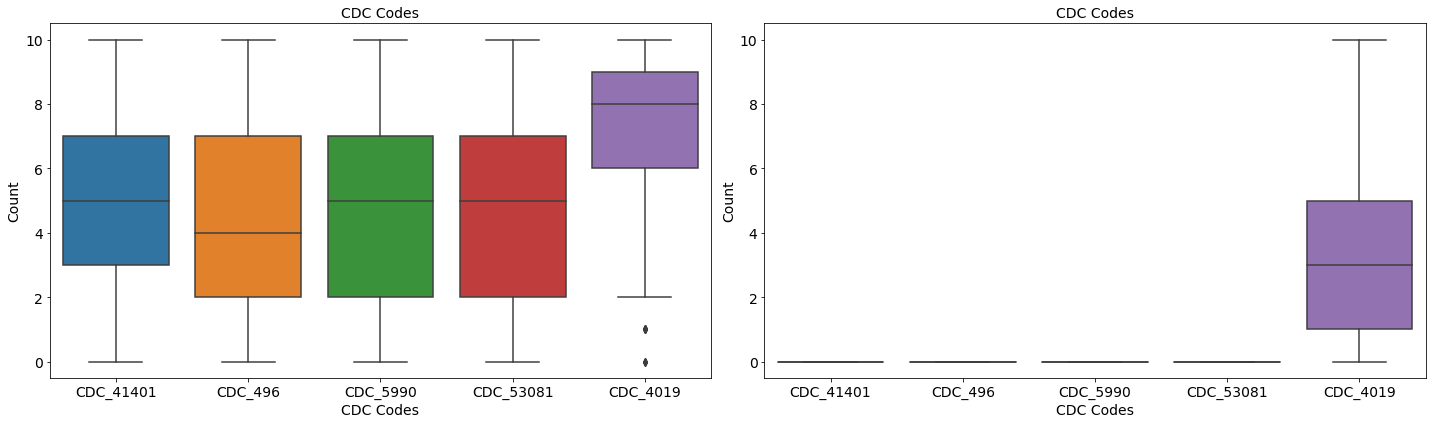

In [180]:
plt.figure(1)
plt.subplot(1, 2, 1)
df1 = Fraud_df[['CDC_41401', 'CDC_496', 'CDC_496', 'CDC_5990', 'CDC_53081', 'CDC_4019']]

sns.boxplot(x = "variable", y = "value", data = pd.melt(df1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('CDC Codes', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('CDC Codes', fontsize = 14)

plt.subplot(1, 2, 2)
df2 = NFraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'CDC_4019']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df2))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('CDC Codes', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('CDC Codes', fontsize = 14)
plt.tight_layout()
plt.show()

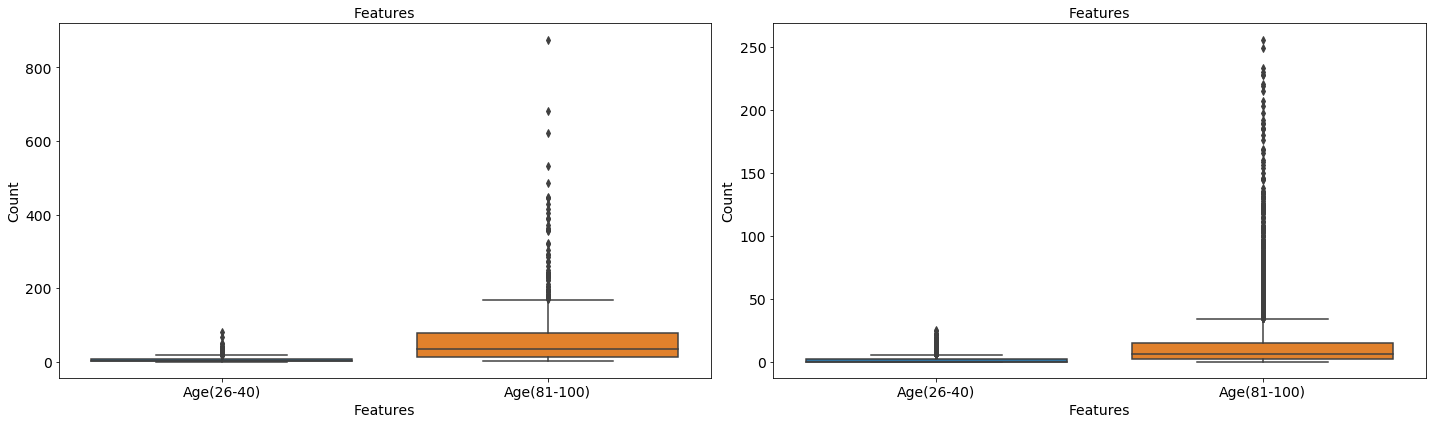

In [207]:
plt.figure(1)
plt.subplot(1, 2, 1)
df1 = Fraud_df[['Age(26-40)',  'Age(81-100)']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)


plt.subplot(1, 2, 2)
df2 = NFraud_df[['Age(26-40)',  'Age(81-100)']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df2))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)
plt.tight_layout()
plt.show()

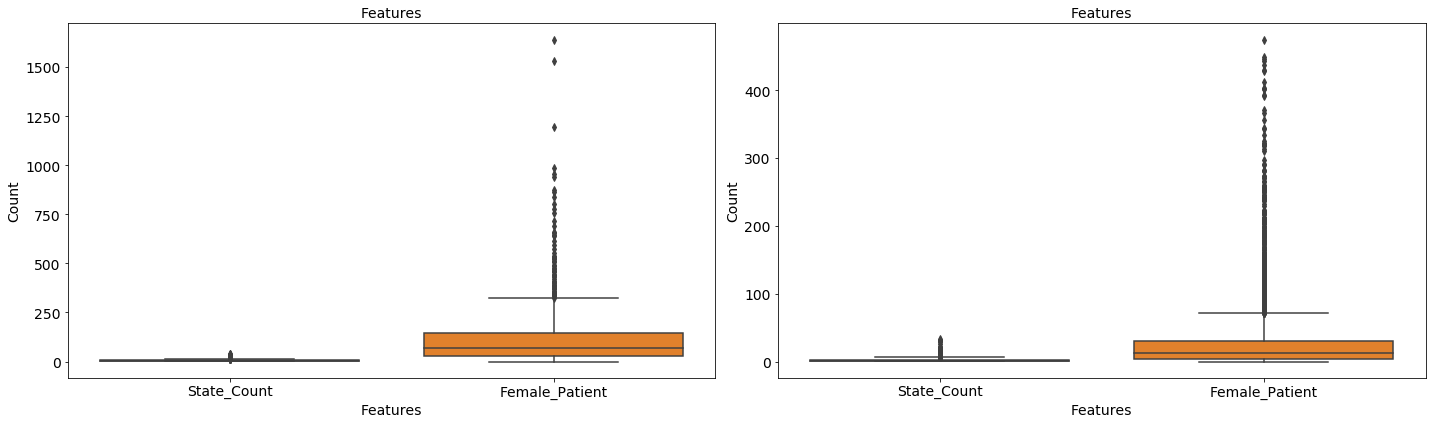

In [208]:
plt.figure(1)
plt.subplot(1, 2, 1)
df1 = Fraud_df[['State_Count',  'Female_Patient']]

sns.boxplot(x = "variable", y = "value", data = pd.melt(df1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)

plt.subplot(1, 2, 2)
df2 = NFraud_df[['State_Count',  'Female_Patient']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df2))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)
plt.tight_layout()
plt.show()

In [76]:
Fraud_CM = Fraud_df.drop('Index', axis = 1).corr().unstack().drop_duplicates().\
to_frame().reset_index().rename(columns = {'level_0' : 'Feature1', 'level_1' : 'Feature2', 0 : 'Corr_Coef'})
Fraud_CM.loc[Fraud_CM.Corr_Coef < 0.91].sort_values(ascending = False, by = 'Corr_Coef').head(15)

,Feature1,Feature2,Corr_Coef
185,Age(41-60),Diabetes,0.909666
179,Age(41-60),Alzheimer,0.909217
430,Race_Hispanic,Race_Native,0.906634
188,Age(41-60),rheumatoidarthritis,0.906371
182,Age(41-60),Cancer,0.903338
1127,State_Count,County_Count,0.893143
189,Age(41-60),stroke,0.892325
127,Age(26-40),KidneyDisease,0.886312
129,Age(26-40),ObstrPulmonary,0.885502
132,Age(26-40),IschemicHeart,0.883842


In [77]:
NFraud_CM = NFraud_df.drop('Index', axis = 1).corr().unstack().drop_duplicates().\
to_frame().reset_index().rename(columns = {'level_0' : 'Feature1', 'level_1' : 'Feature2', 0 : 'Corr_Coef'})
NFraud_CM.loc[NFraud_CM.Corr_Coef < 0.91].sort_values(ascending = False, by = 'Corr_Coef').head(15)

,Feature1,Feature2,Corr_Coef
186,Age(41-60),IschemicHeart,0.909658
180,Age(41-60),Heartfailure,0.908376
181,Age(41-60),KidneyDisease,0.904854
184,Age(41-60),Depression,0.903741
187,Age(41-60),Osteoporasis,0.901695
183,Age(41-60),ObstrPulmonary,0.901632
295,Age(81-100),RenalDisease,0.901625
345,Race_White,stroke,0.900817
179,Age(41-60),Alzheimer,0.900430
188,Age(41-60),rheumatoidarthritis,0.899790
